# Plotting Wrappers

> Plotting Wrappers

In [ ]:
#| default_exp _plotting/wrappers

In [ ]:
#| export
#| echo: false
import warnings
import matplotlib.pyplot as plt
from matplotlib.ticker import (
    StrMethodFormatter,
    FuncFormatter
)

import numpy as np
from pandas import DataFrame as df
import seaborn as sns

from hypersheets import (
    stats as _stats, utils as _utils)
from hypersheets._plotting import (
    core as _core)

In [ ]:
#| hide
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [ ]:
#| export
#| echo: false
# Define global color variables

FLATUI_COLORS = ["#696969", "#348dc1", "#af4b64",#fedd78->#696969 #348dc1->#0000FF
                  "#4fa487", "#9b59b6", "#808080"]
GRAYSCALE_COLORS = ['silver', '#222222', 'gray'] * 3

# check for plotly
_HAS_PLOTLY = False
try:
    import plotly
    _HAS_PLOTLY = True
except ImportError:
    pass

In [ ]:
#| export
def to_plotly(fig):
    if not _HAS_PLOTLY:
        return fig
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        fig = plotly.tools.mpl_to_plotly(fig)
        return plotly.plotly.iplot(fig, filename='quantstats-plot',
                                   overwrite=True)

In [ ]:
def snapshot(returns, grayscale=False, figsize=(10, 8),
             title='Portfolio Summary', fontname='Arial', lw=1.5,
             mode="comp", subtitle=True, savefig=None, show=True,
             log_scale=False):

    colors = GRAYSCALE_COLORS if grayscale else FLATUI_COLORS

    returns = _utils.make_portfolio(returns, 1, mode).pct_change().fillna(0)

    if figsize is None:
        size = list(plt.gcf().get_size_inches())
        figsize = (size[0], size[0]*.75)

    fig, axes = plt.subplots(3, 1, sharex=True, figsize=figsize,
                              gridspec_kw={'height_ratios': [3, 1, 1]})

    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)

    fig.suptitle(title, fontsize=14, y=.995,
                 fontname=fontname, fontweight='bold', color='black')

    fig.set_facecolor('white')

    if subtitle:
        axes[0].set_title("\n%s - %s ;  Sharpe: %.2f                      " % (
            returns.index.date[:1][0].strftime('%e %b \'%y'),
            returns.index.date[-1:][0].strftime('%e %b \'%y'),
            _stats.sharpe(returns)
        ), fontsize=12, color='gray')

    axes[0].set_ylabel('Cumulative Return', fontname=fontname,
                       fontweight='bold', fontsize=12)
    axes[0].plot(_stats.compsum(returns) * 100, color=colors[1],
                 lw=1 if grayscale else lw, zorder=1)
    axes[0].axhline(0, color='silver', lw=1, zorder=0)

    axes[0].set_yscale("symlog" if log_scale else "linear")

    dd = _stats.to_drawdown_series(returns) * 100
    ddmin = _utils.round_to_closest(abs(dd.min()), 5)
    ddmin_ticks = 5
    if ddmin > 50:
        ddmin_ticks = ddmin / 4
    elif ddmin > 20:
        ddmin_ticks = ddmin / 3
    ddmin_ticks = int(_utils.round_to_closest(ddmin_ticks, 5))

    # ddmin_ticks = int(_utils._round_to_closest(ddmin, 5))
    axes[1].set_ylabel('Drawdown', fontname=fontname,
                       fontweight='bold', fontsize=12)
    axes[1].set_yticks(np.arange(-ddmin, 0, step=ddmin_ticks))
    axes[1].plot(dd, color=colors[2], lw=1 if grayscale else lw, zorder=1)
    axes[1].axhline(0, color='silver', lw=1, zorder=0)
    if not grayscale:
        axes[1].fill_between(dd.index, 0, dd, color=colors[2], alpha=.1)

    axes[1].set_yscale("symlog" if log_scale else "linear")

    axes[2].set_ylabel('Daily Return', fontname=fontname,
                       fontweight='bold', fontsize=12)
    axes[2].plot(returns * 100, color=colors[0], lw=0.5, zorder=1)
    axes[2].axhline(0, color='silver', lw=1, zorder=0)
    axes[2].axhline(0, color=colors[-1], linestyle='--', lw=1, zorder=2)

    axes[2].set_yscale("symlog" if log_scale else "linear")

    retmax = _utils.round_to_closest(returns.max() * 100, 5)
    retmin = _utils.round_to_closest(returns.min() * 100, 5)
    retdiff = (retmax - retmin)
    steps = 5
    if retdiff > 50:
        steps = retdiff / 5
    elif retdiff > 30:
        steps = retdiff / 4
    steps = int(_utils.round_to_closest(steps, 5))
    axes[2].set_yticks(np.arange(retmin, retmax, step=steps))

    for ax in axes:
        ax.set_facecolor('white')
        ax.yaxis.set_label_coords(-.1, .5)
        ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}%'))

    plt.subplots_adjust(hspace=0, bottom=0, top=1)
    fig.autofmt_xdate()

    try:
        plt.subplots_adjust(hspace=0)
    except Exception:
        pass
    try:
        fig.tight_layout(w_pad=0, h_pad=0)
    except Exception:
        pass

    if savefig:
        if isinstance(savefig, dict):
            plt.savefig(**savefig)
        else:
            plt.savefig(savefig)

    if show:
        plt.show(block=False)

    plt.close()

    if not show:
        return fig

    return None

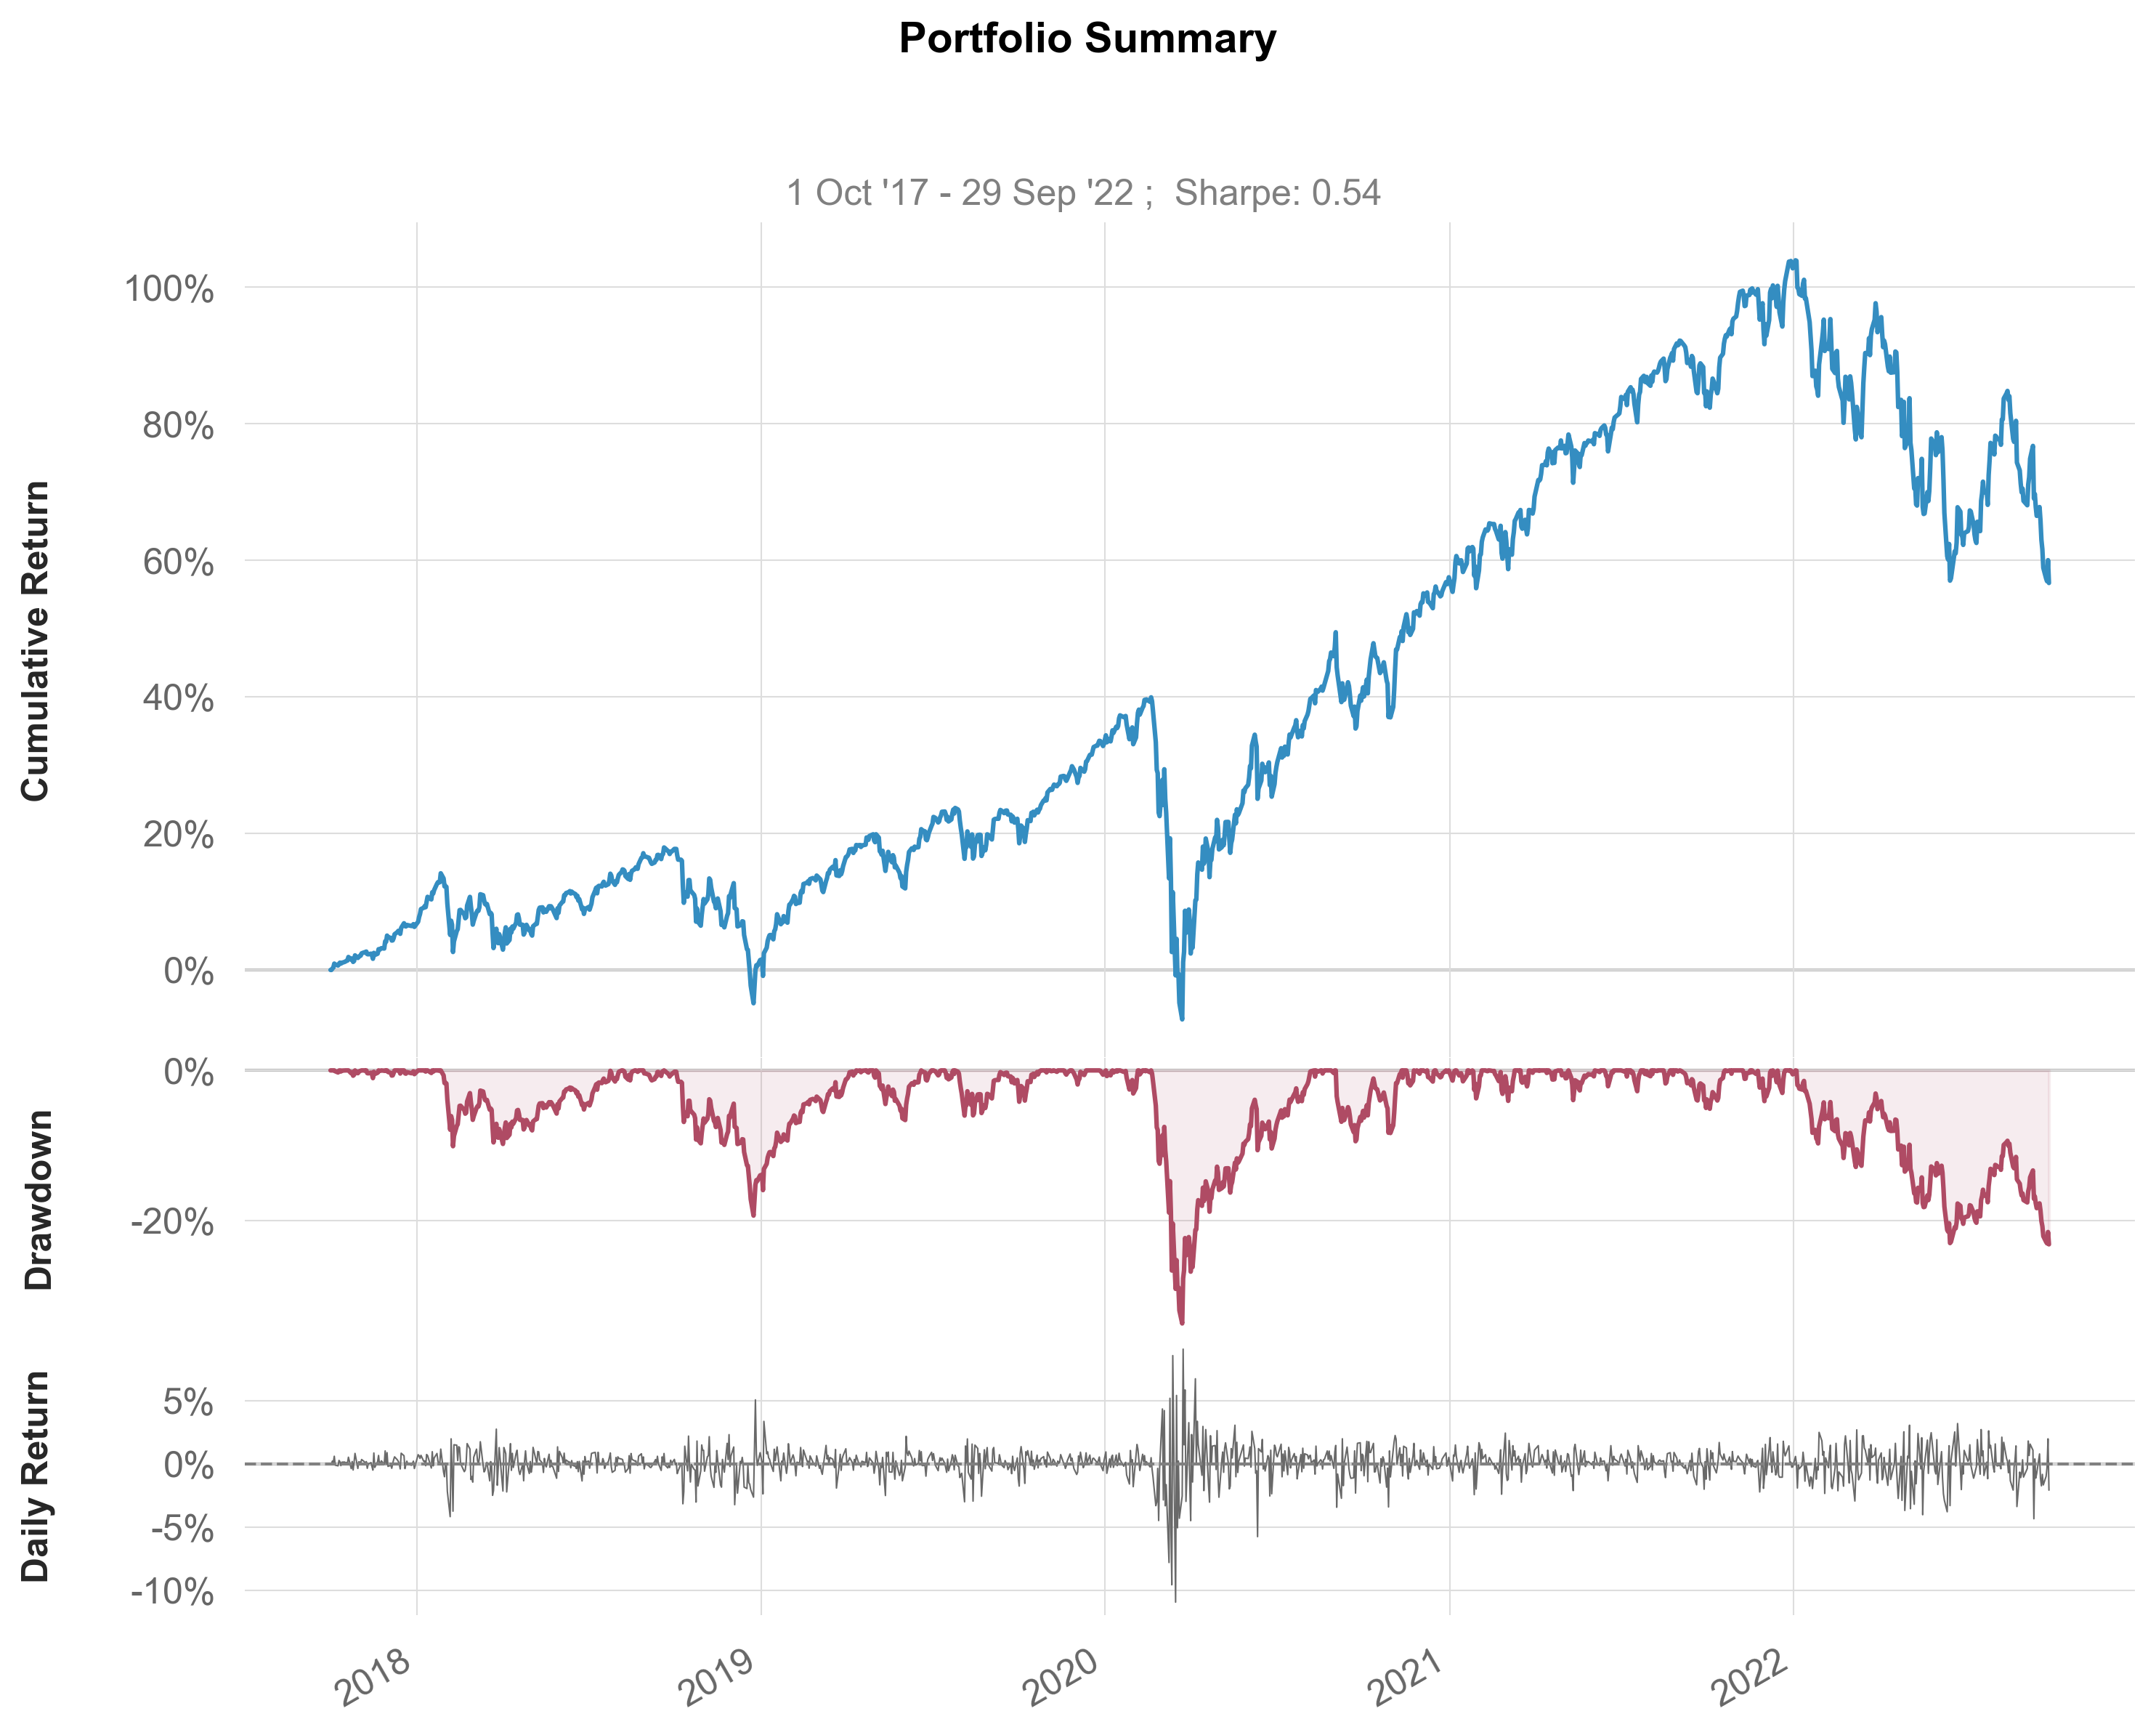

In [ ]:
#| eval: false
values = _utils.download_returns('SPY', '5y')
snapshot(values)

In [ ]:
def earnings(returns, start_balance=1e5, mode="comp",
             grayscale=False, figsize=(10, 6),
             title='Portfolio Earnings',
             fontname='Arial', lw=1.5,
             subtitle=True, savefig=None, show=True):

    colors = GRAYSCALE_COLORS if grayscale else FLATUI_COLORS
    alpha = .5 if grayscale else .8

    returns = _utils.make_portfolio(returns, start_balance, mode)

    if figsize is None:
        size = list(plt.gcf().get_size_inches())
        figsize = (size[0], size[0]*.55)

    fig, ax = plt.subplots(figsize=figsize)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    fig.suptitle(title, fontsize=14, y=.995,
                 fontname=fontname, fontweight='bold', color='black')

    if subtitle:
        ax.set_title("\n%s - %s ;  P&L: %s (%s)                " % (
            returns.index.date[1:2][0].strftime('%e %b \'%y'),
            returns.index.date[-1:][0].strftime('%e %b \'%y'),
            _utils._score_str("${:,}".format(
                round(returns.values[-1]-returns.values[0], 2))),
            _utils._score_str("{:,}%".format(
                round((returns.values[-1]/returns.values[0]-1)*100, 2)))
        ), fontsize=12, color='gray')

    mx = returns.max()
    returns_max = returns[returns == mx]
    ix = returns_max[~np.isnan(returns_max)].index[0]
    returns_max = np.where(returns.index == ix, mx, np.nan)

    ax.plot(returns.index, returns_max, marker='o', lw=0,
            alpha=alpha, markersize=12, color=colors[0] if grayscale else 'pink'
            )

    ax.plot(returns.index, returns, colors[1],
            lw=1 if grayscale else lw)

    ax.set_ylabel('Value of  ${:,.0f}'.format(start_balance),
                  fontname=fontname, fontweight='bold', fontsize=12)

    ax.yaxis.set_major_formatter(FuncFormatter(_core.format_cur_axis))
    ax.yaxis.set_label_coords(-.1, .5)

    fig.set_facecolor('white')
    ax.set_facecolor('white')
    fig.autofmt_xdate()

    try:
        plt.subplots_adjust(hspace=0)
    except Exception:
        pass
    try:
        fig.tight_layout(w_pad=0, h_pad=0)
    except Exception:
        pass

    if savefig:
        if isinstance(savefig, dict):
            plt.savefig(**savefig)
        else:
            plt.savefig(savefig)

    if show:
        plt.show(block=False)

    plt.close()

    if not show:
        return fig

    return None

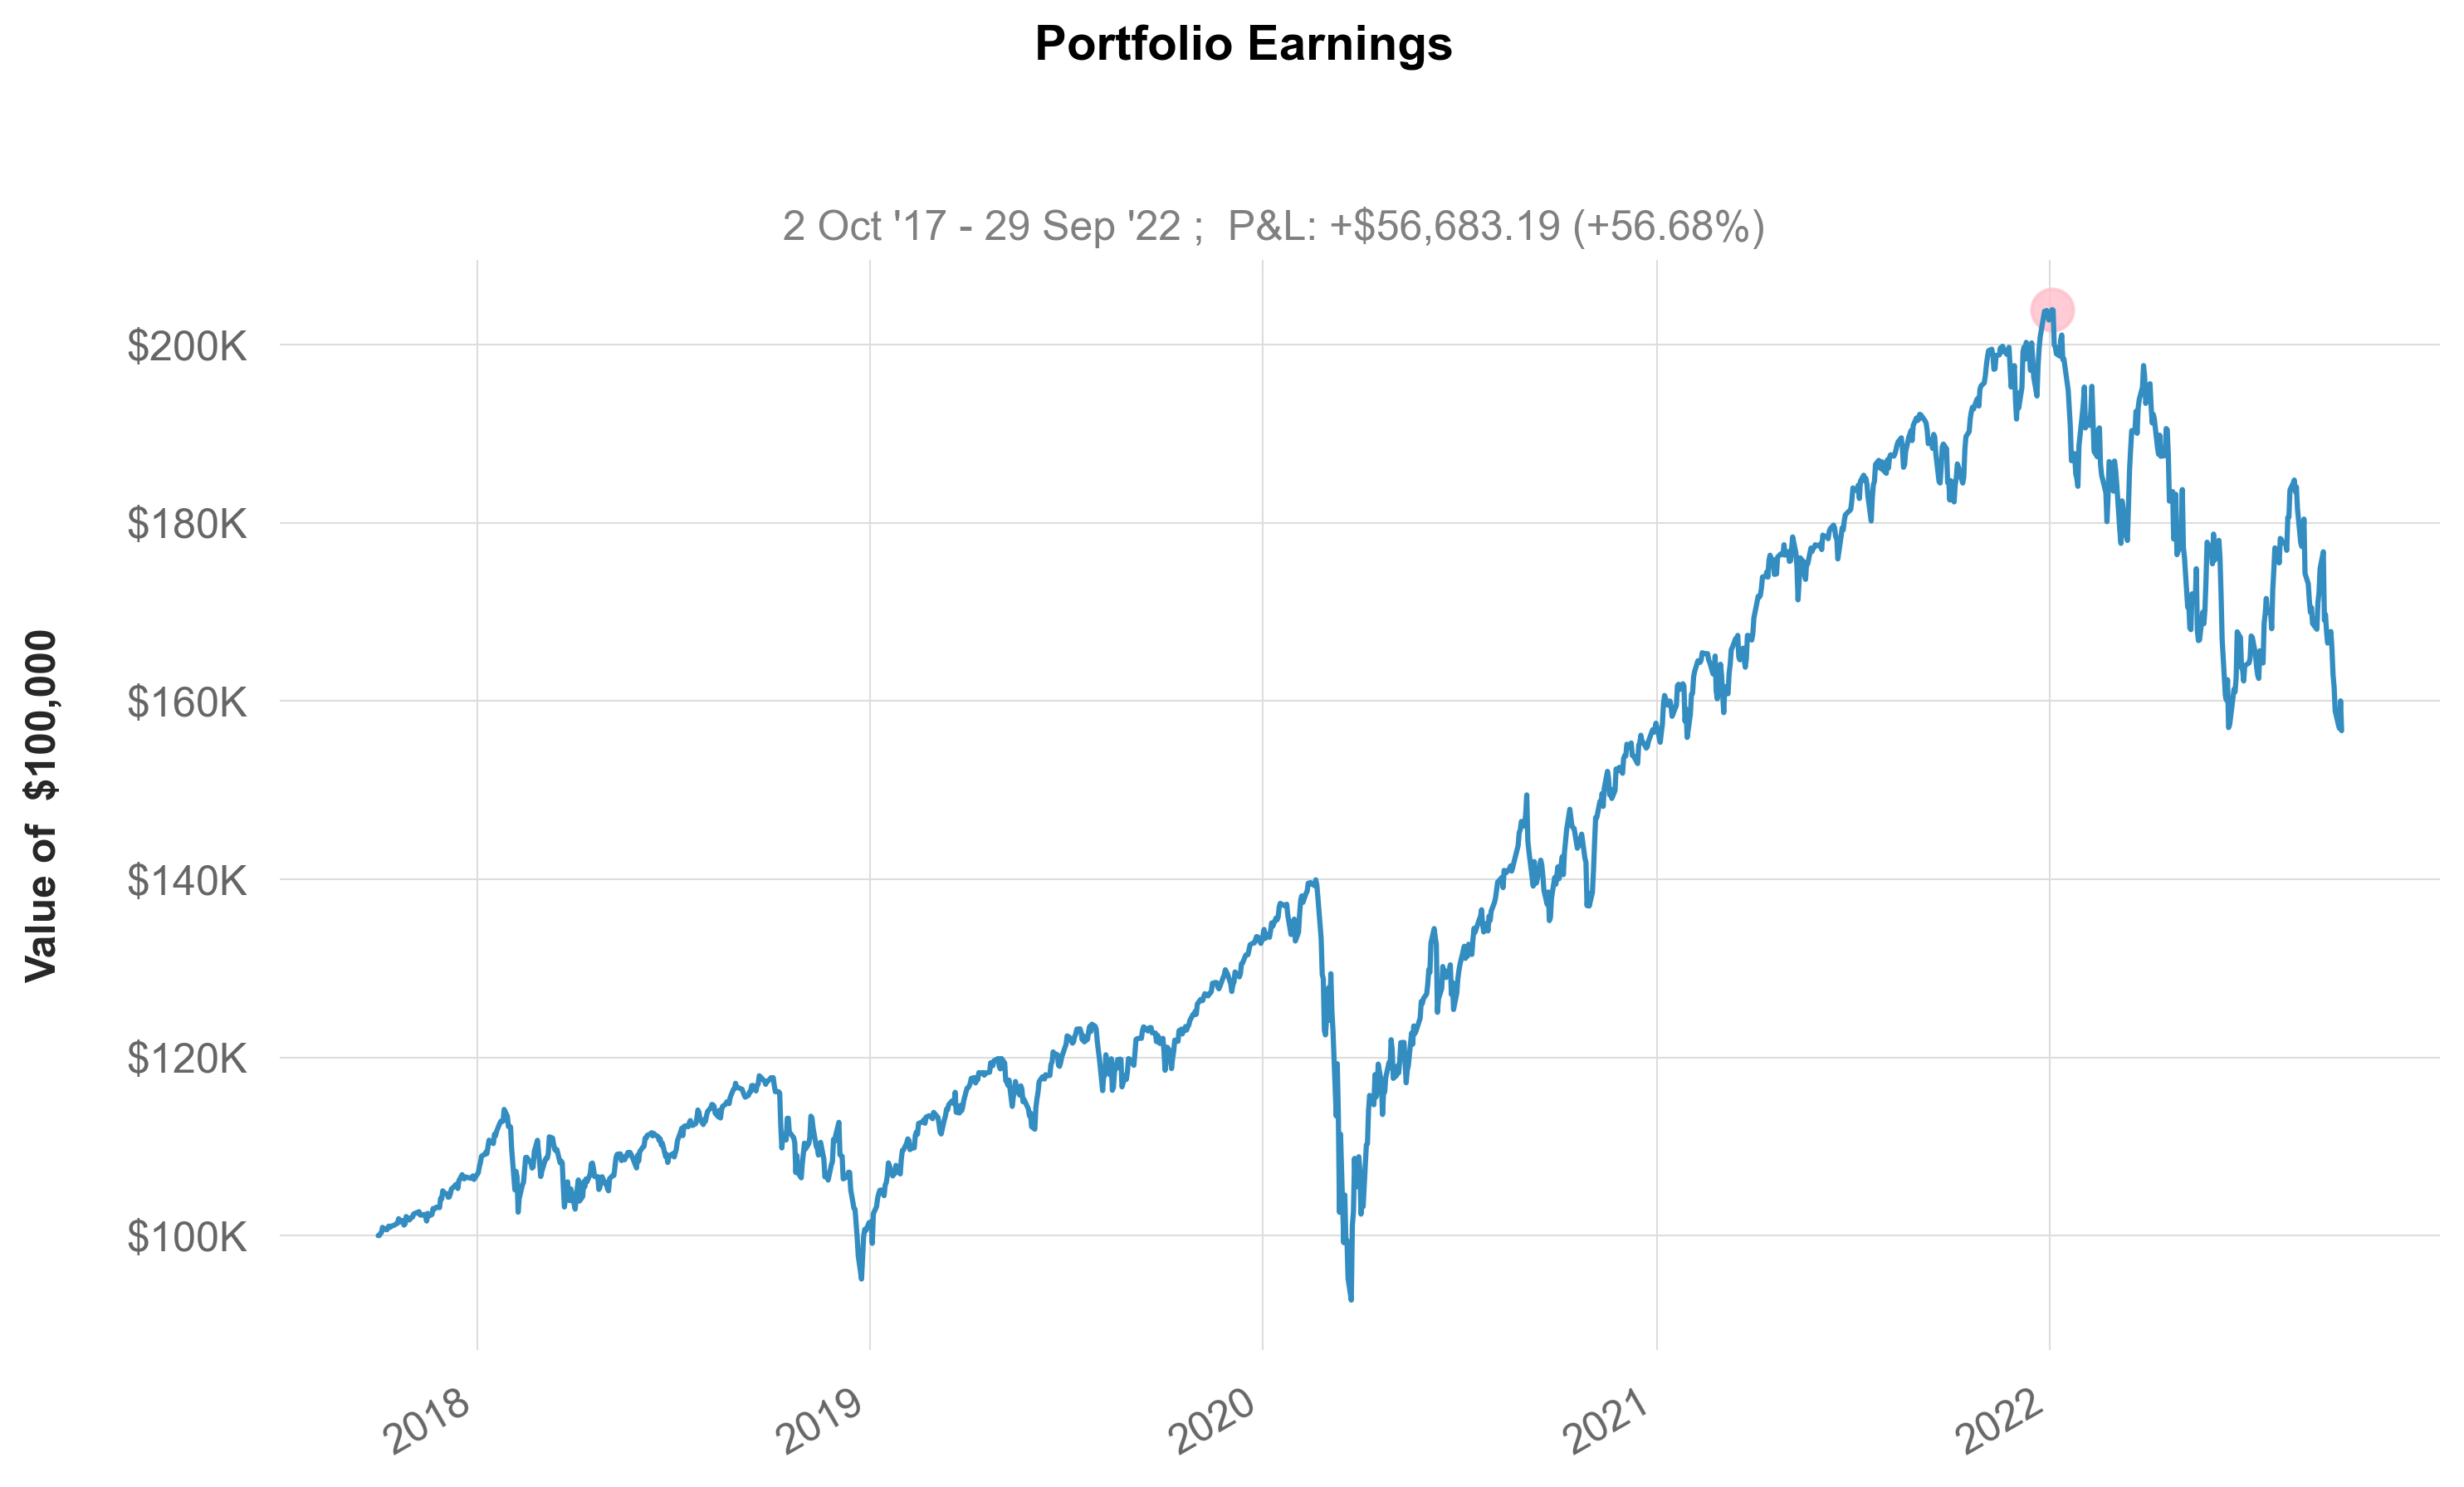

In [ ]:
#| eval: false
values = _utils.download_returns('SPY', '5y')
earnings(values)

In [ ]:
#| export
def returns(returns, benchmark=None,
            grayscale=False, figsize=(10, 6),
            returns_label="Strategy", benchmark_label="Benchmark",
            fontname='Arial', lw=1.5,
            match_volatility=False, compound=True, cumulative=True,
            resample=None, ylabel="Cumulative Returns",
            subtitle=True, savefig=None, show=True,
            prepare_returns=False):

    title = 'Cumulative Returns' if compound else 'Returns'
    if benchmark is not None:
        if isinstance(benchmark, str):
            title += ' vs %s' % benchmark.upper()
        else:
            title += ' vs %s' % benchmark_label
        if match_volatility:
            title += ' (Volatility Matched)'

    if prepare_returns:
        returns = _utils.prepare_returns(returns)

    benchmark = _utils.prepare_benchmark(benchmark, returns.index)

    fig = _core.plot_timeseries(returns, benchmark, title,
                                ylabel=ylabel,
                                match_volatility=match_volatility,
                                log_scale=False,
                                resample=resample,
                                compound=compound,
                                cumulative=cumulative,
                                lw=lw,
                                returns_label=returns_label,
                                benchmark_label = benchmark_label,
                                figsize=figsize,
                                fontname=fontname,
                                grayscale=grayscale,
                                subtitle=subtitle,
                                savefig=savefig, show=show)
    if not show:
        return fig

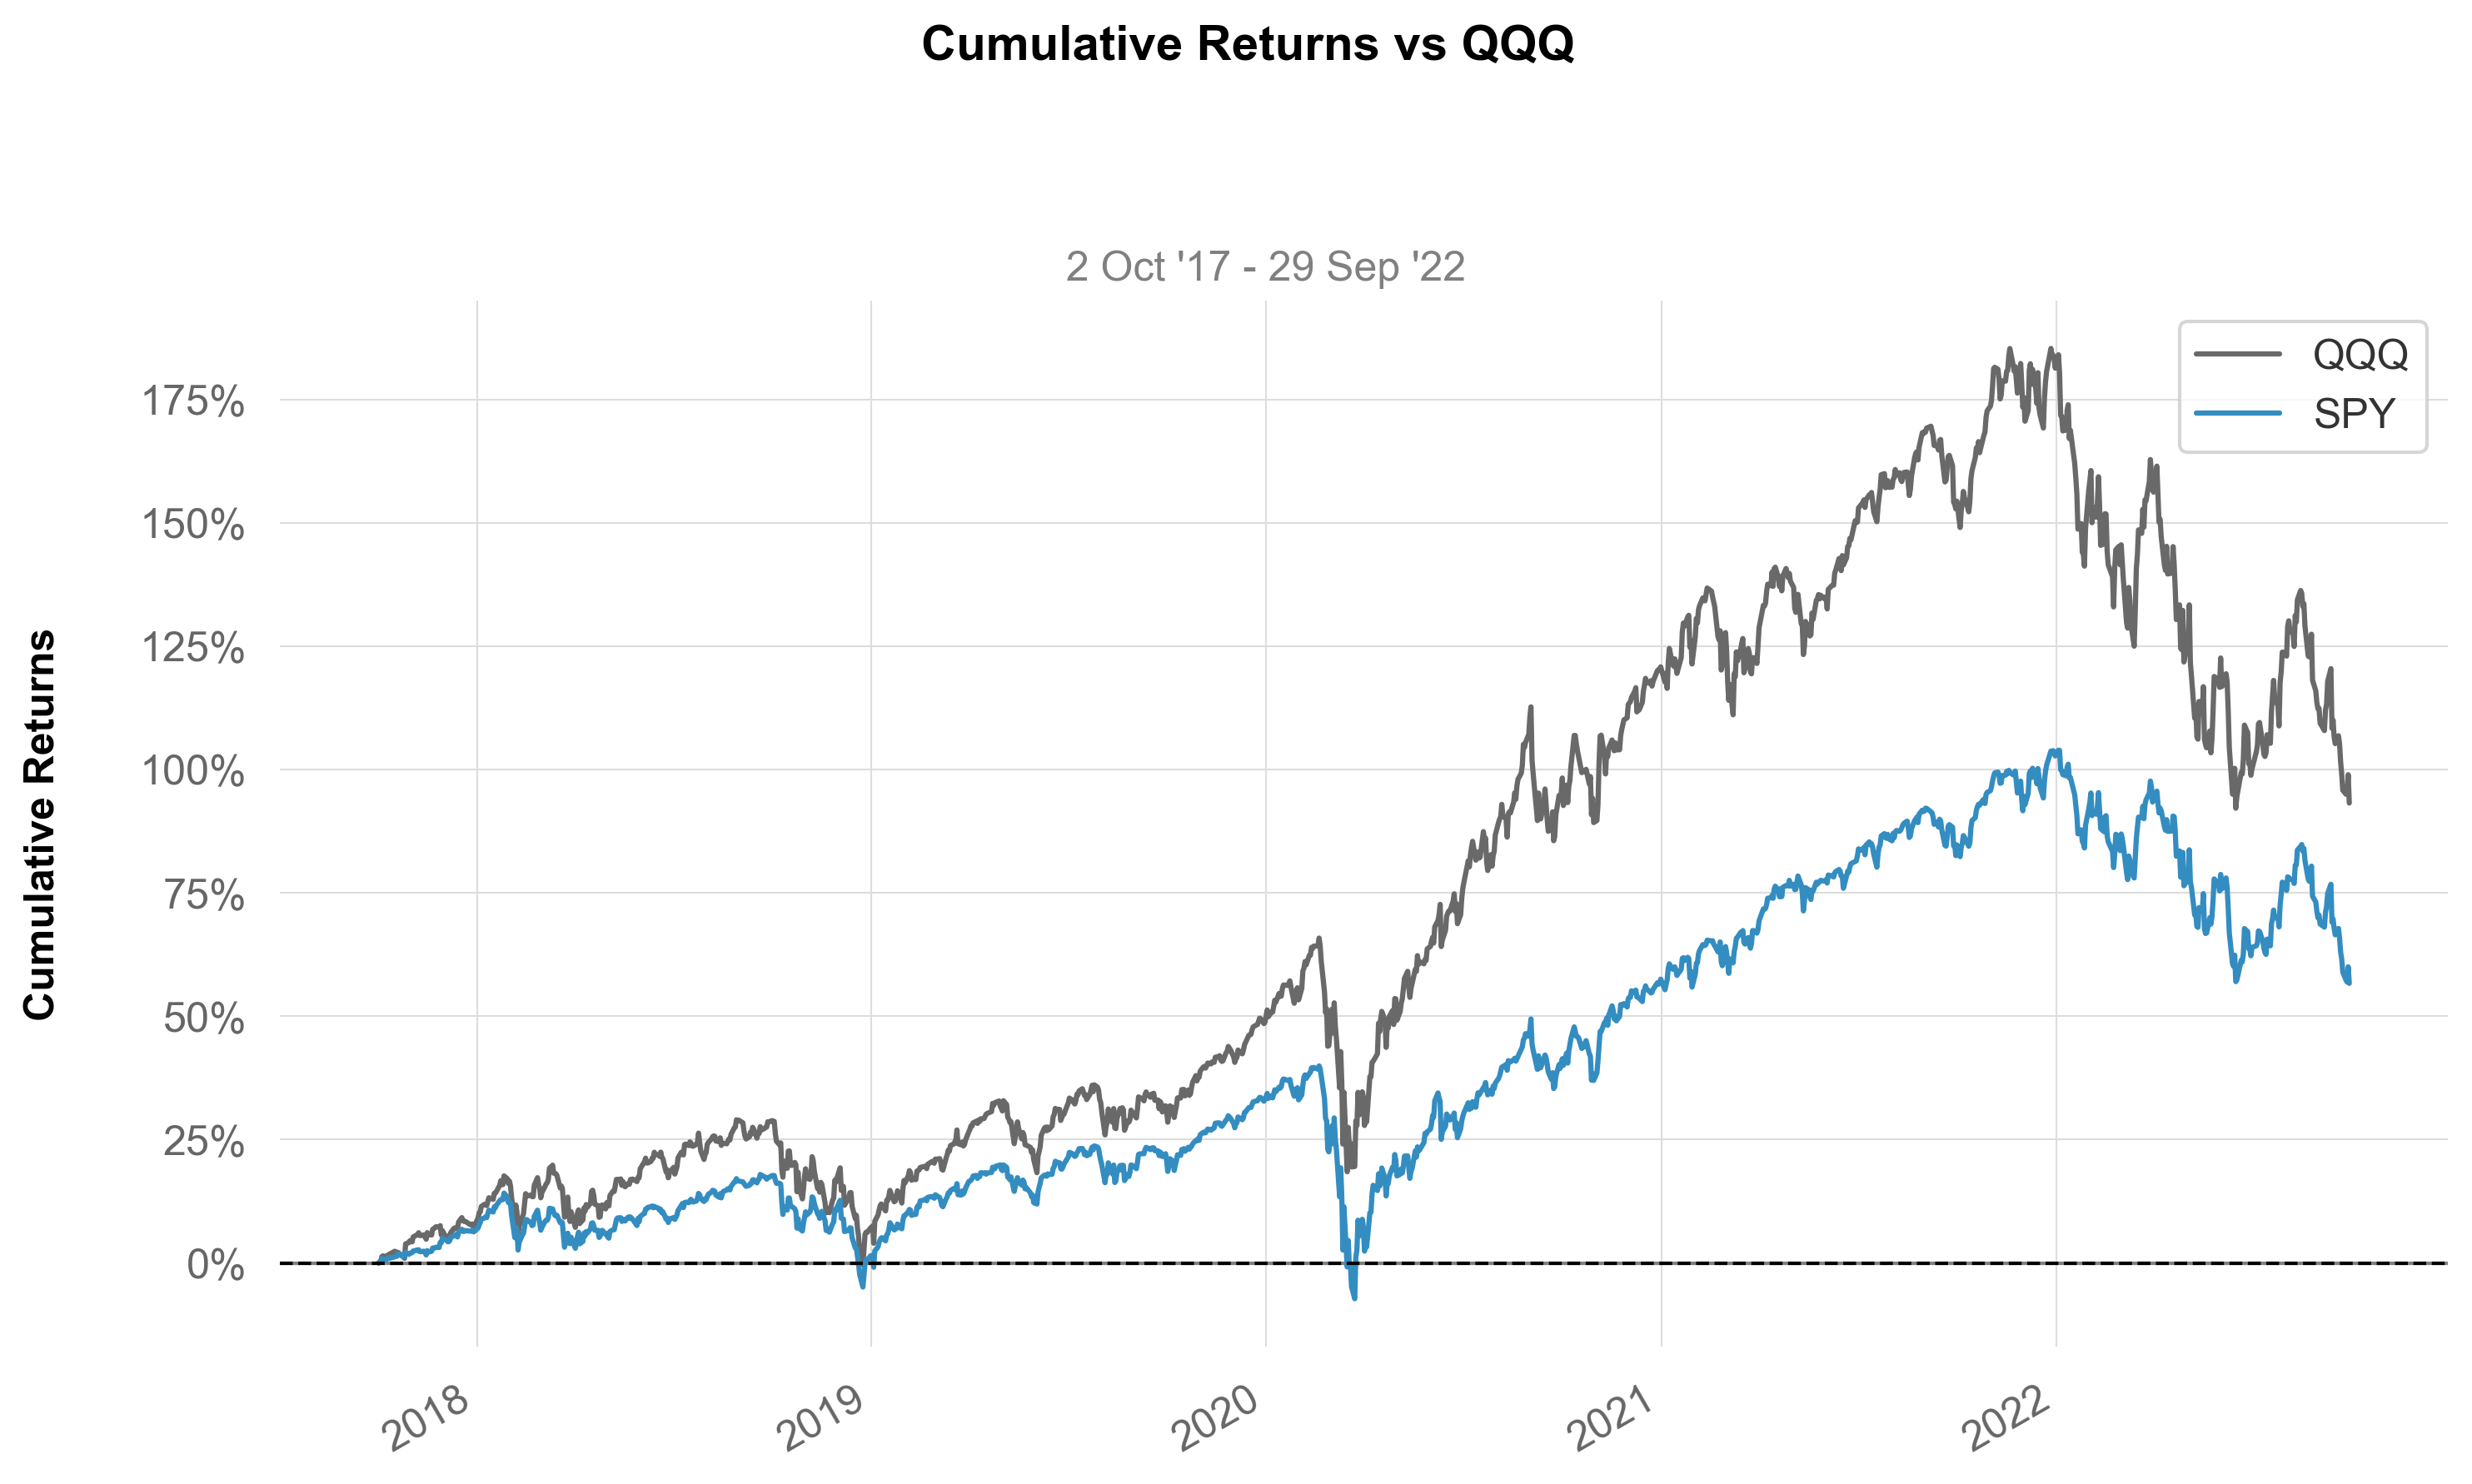

In [ ]:
#| eval: false
values = _utils.download_returns('SPY', '5y')
benchmark = _utils.download_returns('QQQ', '5y')
returns(values, benchmark, returns_label="SPY", benchmark_label="QQQ")

In [ ]:
#| export
def log_returns(returns, benchmark=None,
                grayscale=False, figsize=(10, 5),
                returns_label="Strategy", benchmark_label="Benchmark",
                fontname='Arial', lw=1.5,
                match_volatility=False, compound=True, cumulative=True,
                resample=None, ylabel="Cumulative Returns",
                subtitle=True, savefig=None, show=True,
                prepare_returns=False):

    title = 'Cumulative Returns' if compound else 'Returns'
    if benchmark is not None:
        if isinstance(benchmark, str):
            title += ' vs %s (Log Scaled' % benchmark.upper()
        else:
            title += ' vs %s (Log Scaled'  % benchmark_label
        if match_volatility:
            title += ', Volatility Matched'
    else:
        title += ' (Log Scaled'
    title += ')'

    if prepare_returns:
        returns = _utils.prepare_returns(returns)

    benchmark = _utils.prepare_benchmark(benchmark, returns.index)

    fig = _core.plot_timeseries(returns, benchmark, title,
                                ylabel=ylabel,
                                match_volatility=match_volatility,
                                log_scale=True,
                                resample=resample,
                                compound=compound,
                                cumulative=cumulative,
                                lw=lw,
                                returns_label=returns_label,
                                benchmark_label = benchmark_label,
                                figsize=figsize,
                                fontname=fontname,
                                grayscale=grayscale,
                                subtitle=subtitle,
                                savefig=savefig, show=show)
    if not show:
        return fig


def daily_returns(returns,
                  grayscale=False, figsize=(10, 4),
                  fontname='Arial', lw=0.5,
                  log_scale=False, ylabel="Returns",
                  subtitle=True, savefig=None, show=True,
                  prepare_returns=True):

    if prepare_returns:
        returns = _utils.prepare_returns(returns)

    fig = _core.plot_timeseries(returns, None, 'Daily Returns',
                                ylabel=ylabel,
                                match_volatility=False,
                                log_scale=log_scale,
                                resample='D',
                                compound=False,
                                lw=lw,
                                figsize=figsize,
                                fontname=fontname,
                                grayscale=grayscale,
                                subtitle=subtitle,
                                savefig=savefig, show=show)
    if not show:
        return fig

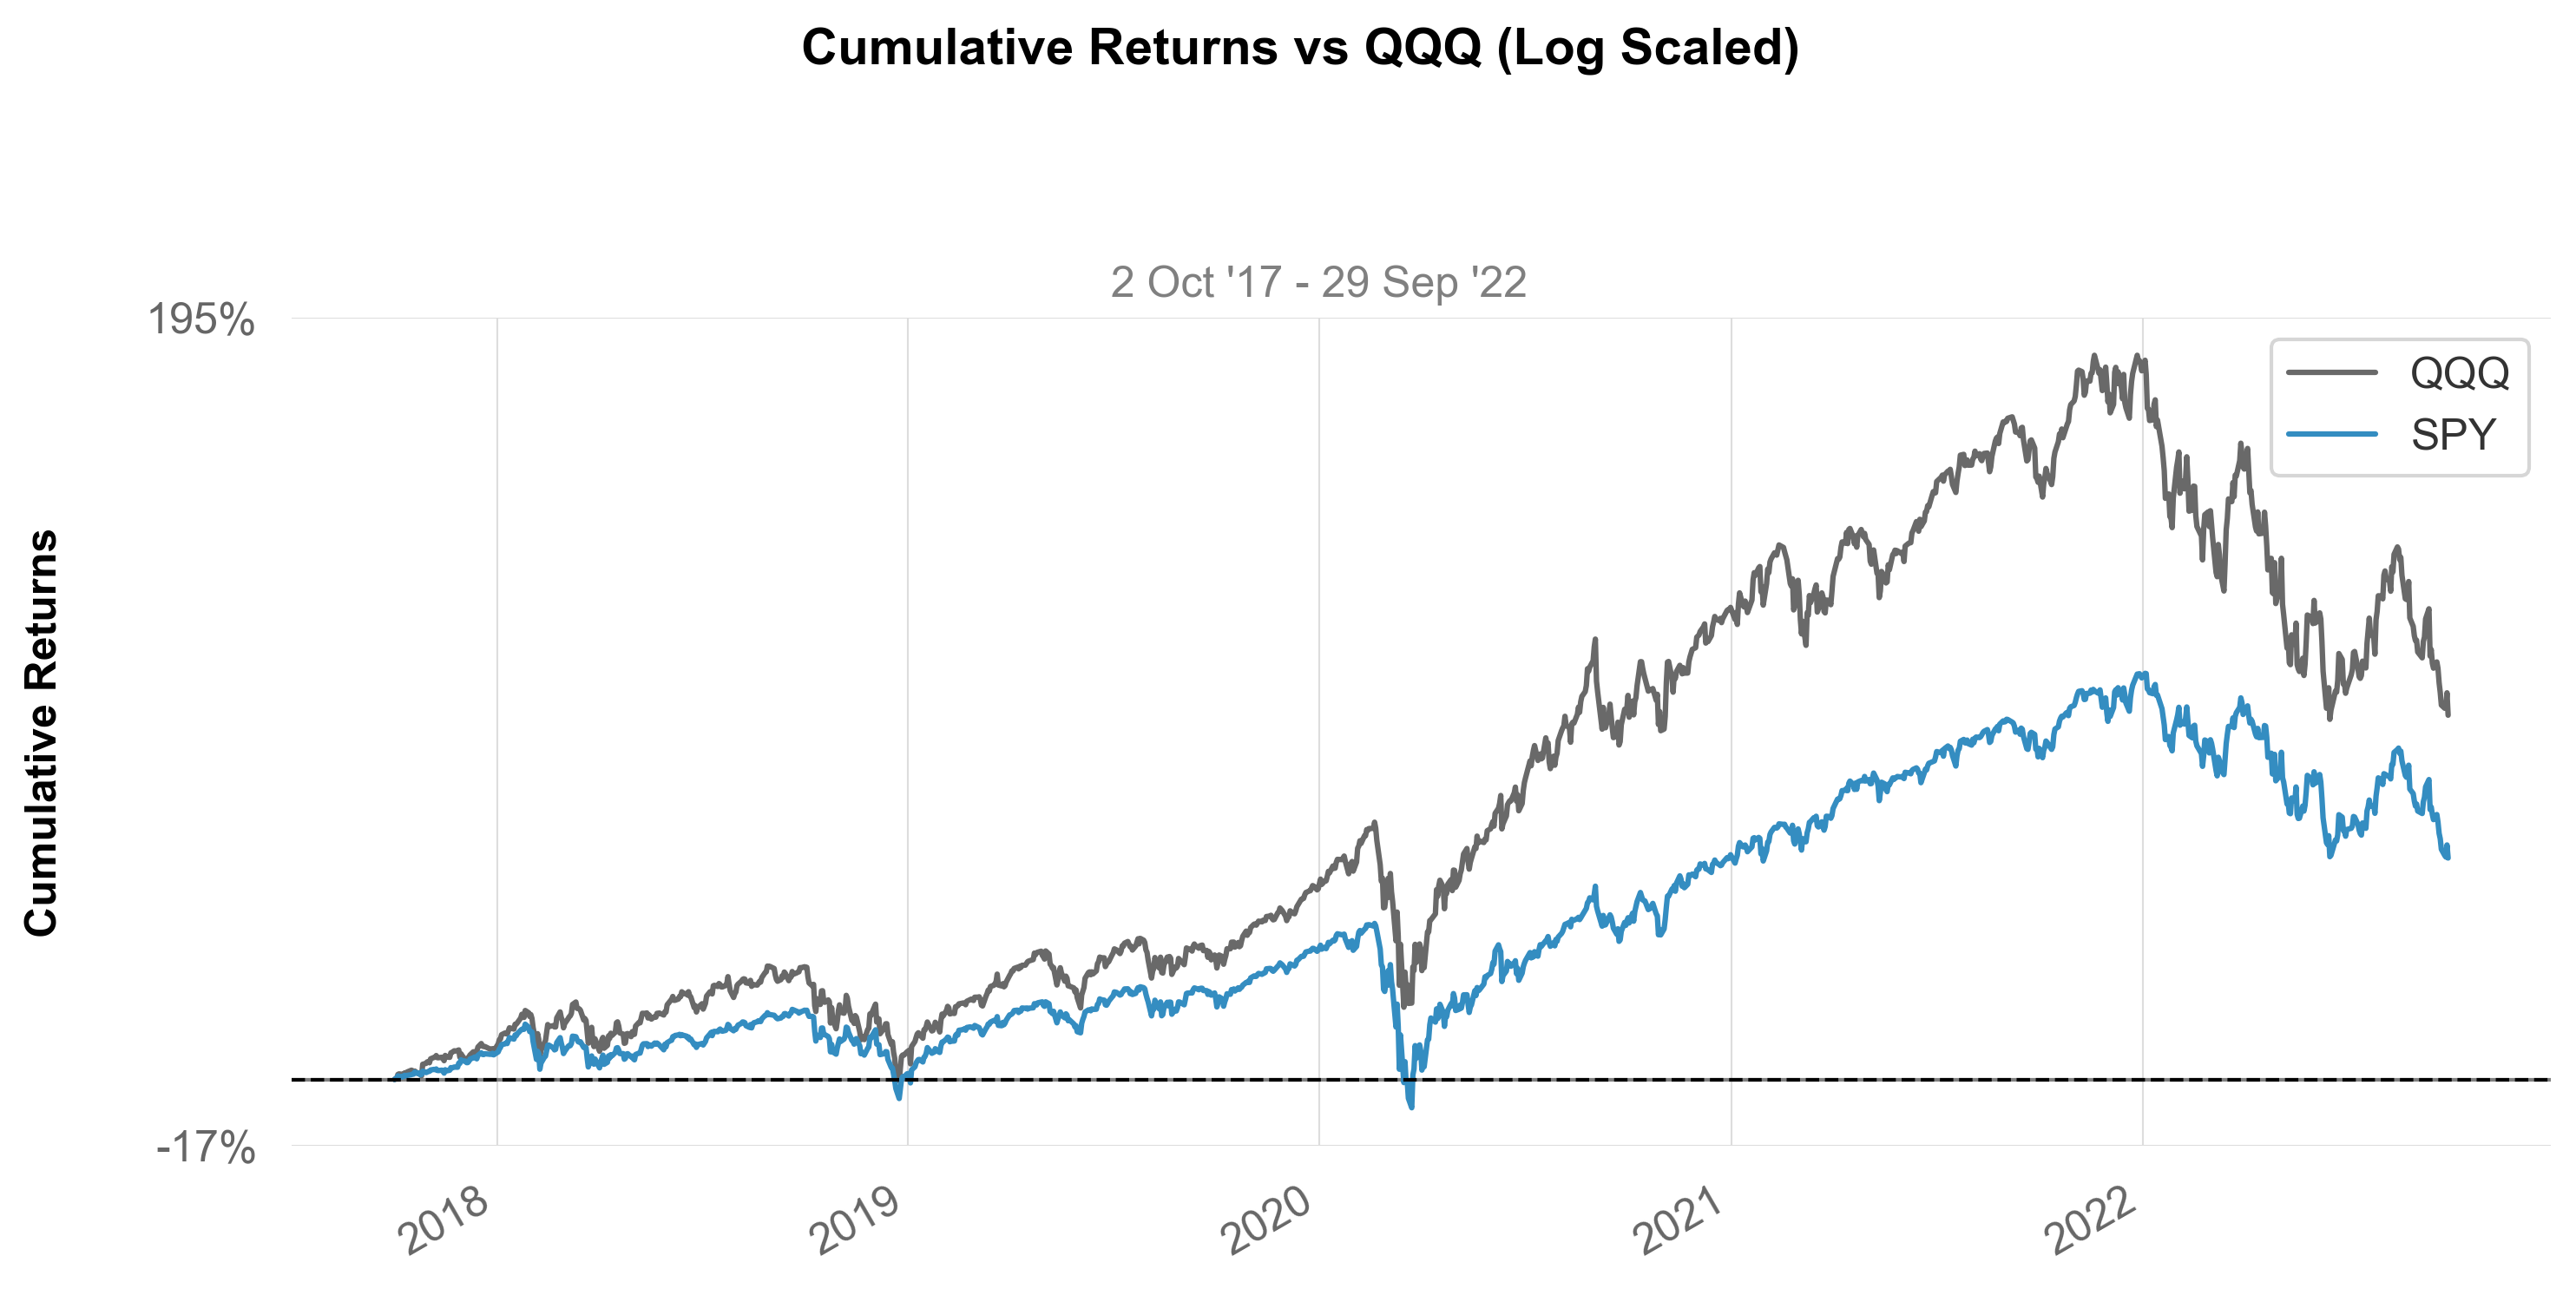

In [ ]:
#| eval: false
values = _utils.download_returns('SPY', '5y')
benchmark = _utils.download_returns('QQQ', '5y')
log_returns(values, benchmark, returns_label="SPY", benchmark_label="QQQ")

In [ ]:
#| export
def yearly_returns(returns, benchmark=None,
                   returns_label="Strategy", benchmark_label="Benchmark",
                   fontname='Arial', grayscale=False,
                   hlw=1.5, hlcolor="red", hllabel="",
                   match_volatility=False,
                   log_scale=False, figsize=(10, 5), ylabel=True,
                   subtitle=True, compounded=True,
                   savefig=None, show=True,
                   prepare_returns=True):

    title = 'EOY Returns'
    if benchmark is not None:
        title += ' vs %s' % benchmark_label
        benchmark = _utils.prepare_benchmark(
            benchmark, returns.index).resample('A').apply(
                _stats.comp).resample('A').last()

    if prepare_returns:
        returns = _utils.prepare_returns(returns)

    if compounded:
        returns = returns.resample('A').apply(_stats.comp)
    else:
        returns = returns.resample('A').apply(df.sum)
    returns = returns.resample('A').last()

    fig = _core.plot_returns_bars(returns, benchmark,
                                  returns_label=returns_label, benchmark_label=benchmark_label,
                                  fontname=fontname,
                                  hline=returns.mean(),
                                  hlw=hlw,
                                  hllabel=hllabel,
                                  hlcolor=hlcolor,
                                  match_volatility=match_volatility,
                                  log_scale=log_scale,
                                  resample=None,
                                  title=title,
                                  figsize=figsize,
                                  grayscale=grayscale,
                                  ylabel=ylabel,
                                  subtitle=subtitle,
                                  savefig=savefig, show=show)
    if not show:
        return fig

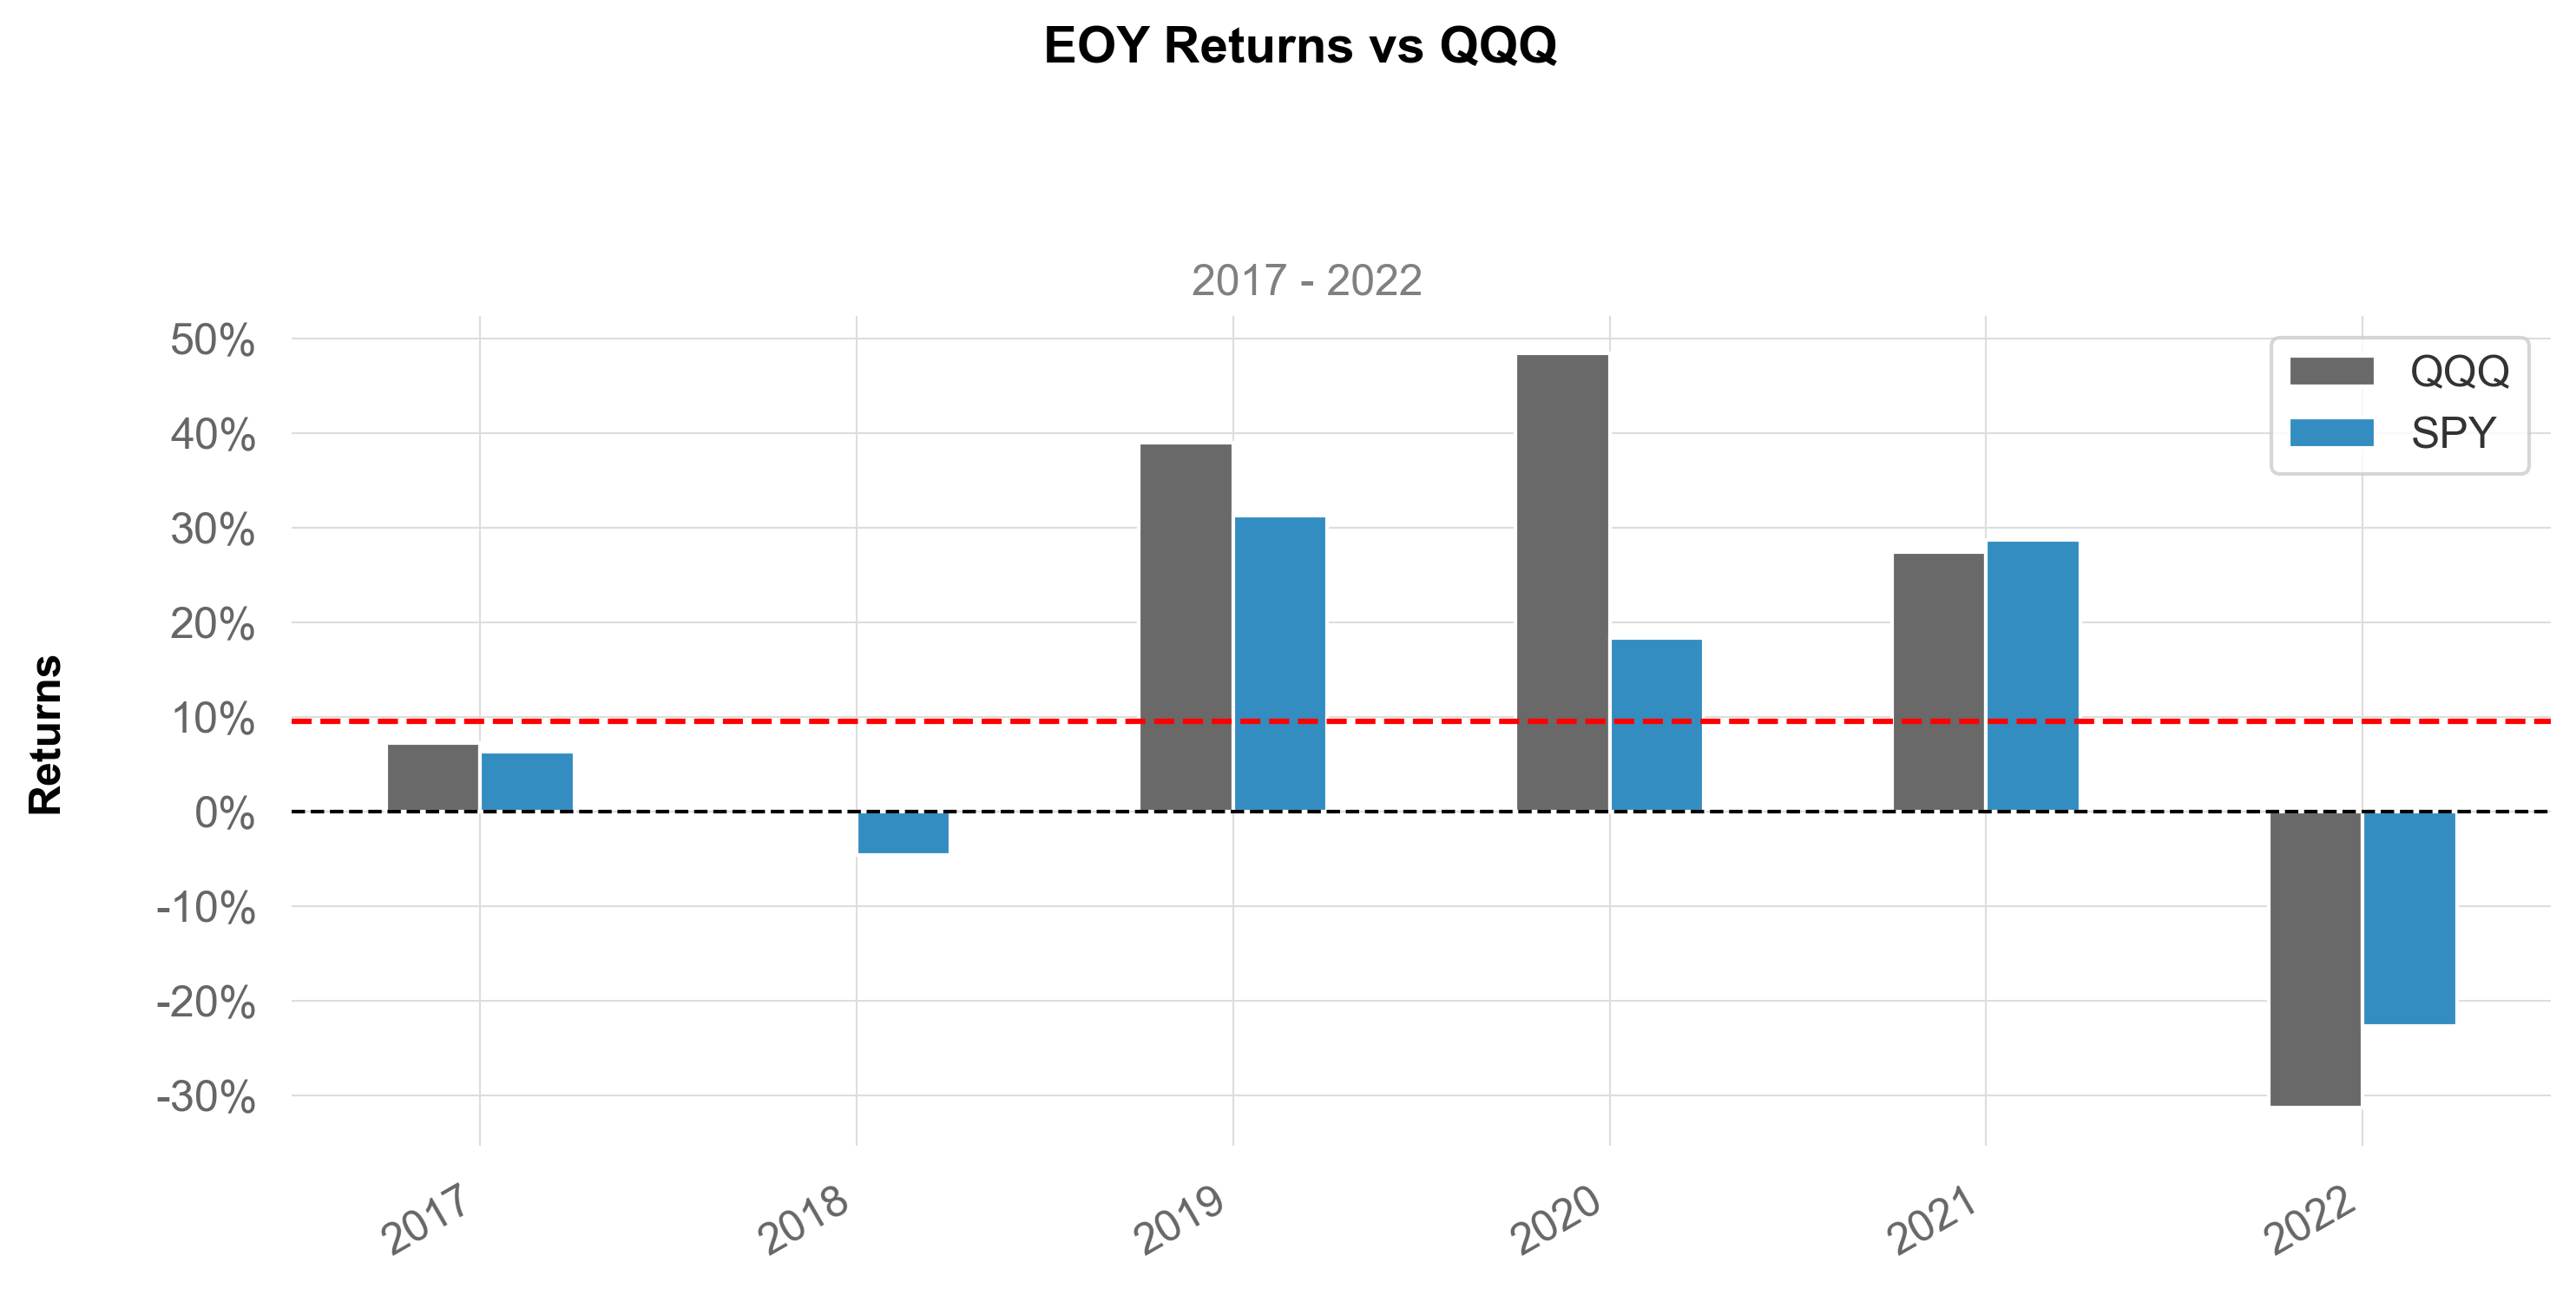

In [ ]:
#| eval: false
values = _utils.download_returns('SPY', '5y')
benchmark = _utils.download_returns('QQQ', '5y')
yearly_returns(values, benchmark, returns_label="SPY", benchmark_label="QQQ")

In [ ]:
#| export
def distribution(returns, fontname='Arial', grayscale=False, ylabel=True,
                 figsize=(10, 6), subtitle=True, compounded=True,
                 savefig=None, show=True,
                 prepare_returns=True):
    if prepare_returns:
        returns = _utils.prepare_returns(returns)

    fig = _core.plot_distribution(returns,
                                  fontname=fontname,
                                  grayscale=grayscale,
                                  figsize=figsize,
                                  ylabel=ylabel,
                                  subtitle=subtitle,
                                  compounded=compounded,
                                  savefig=savefig, show=show)
    if not show:
        return fig

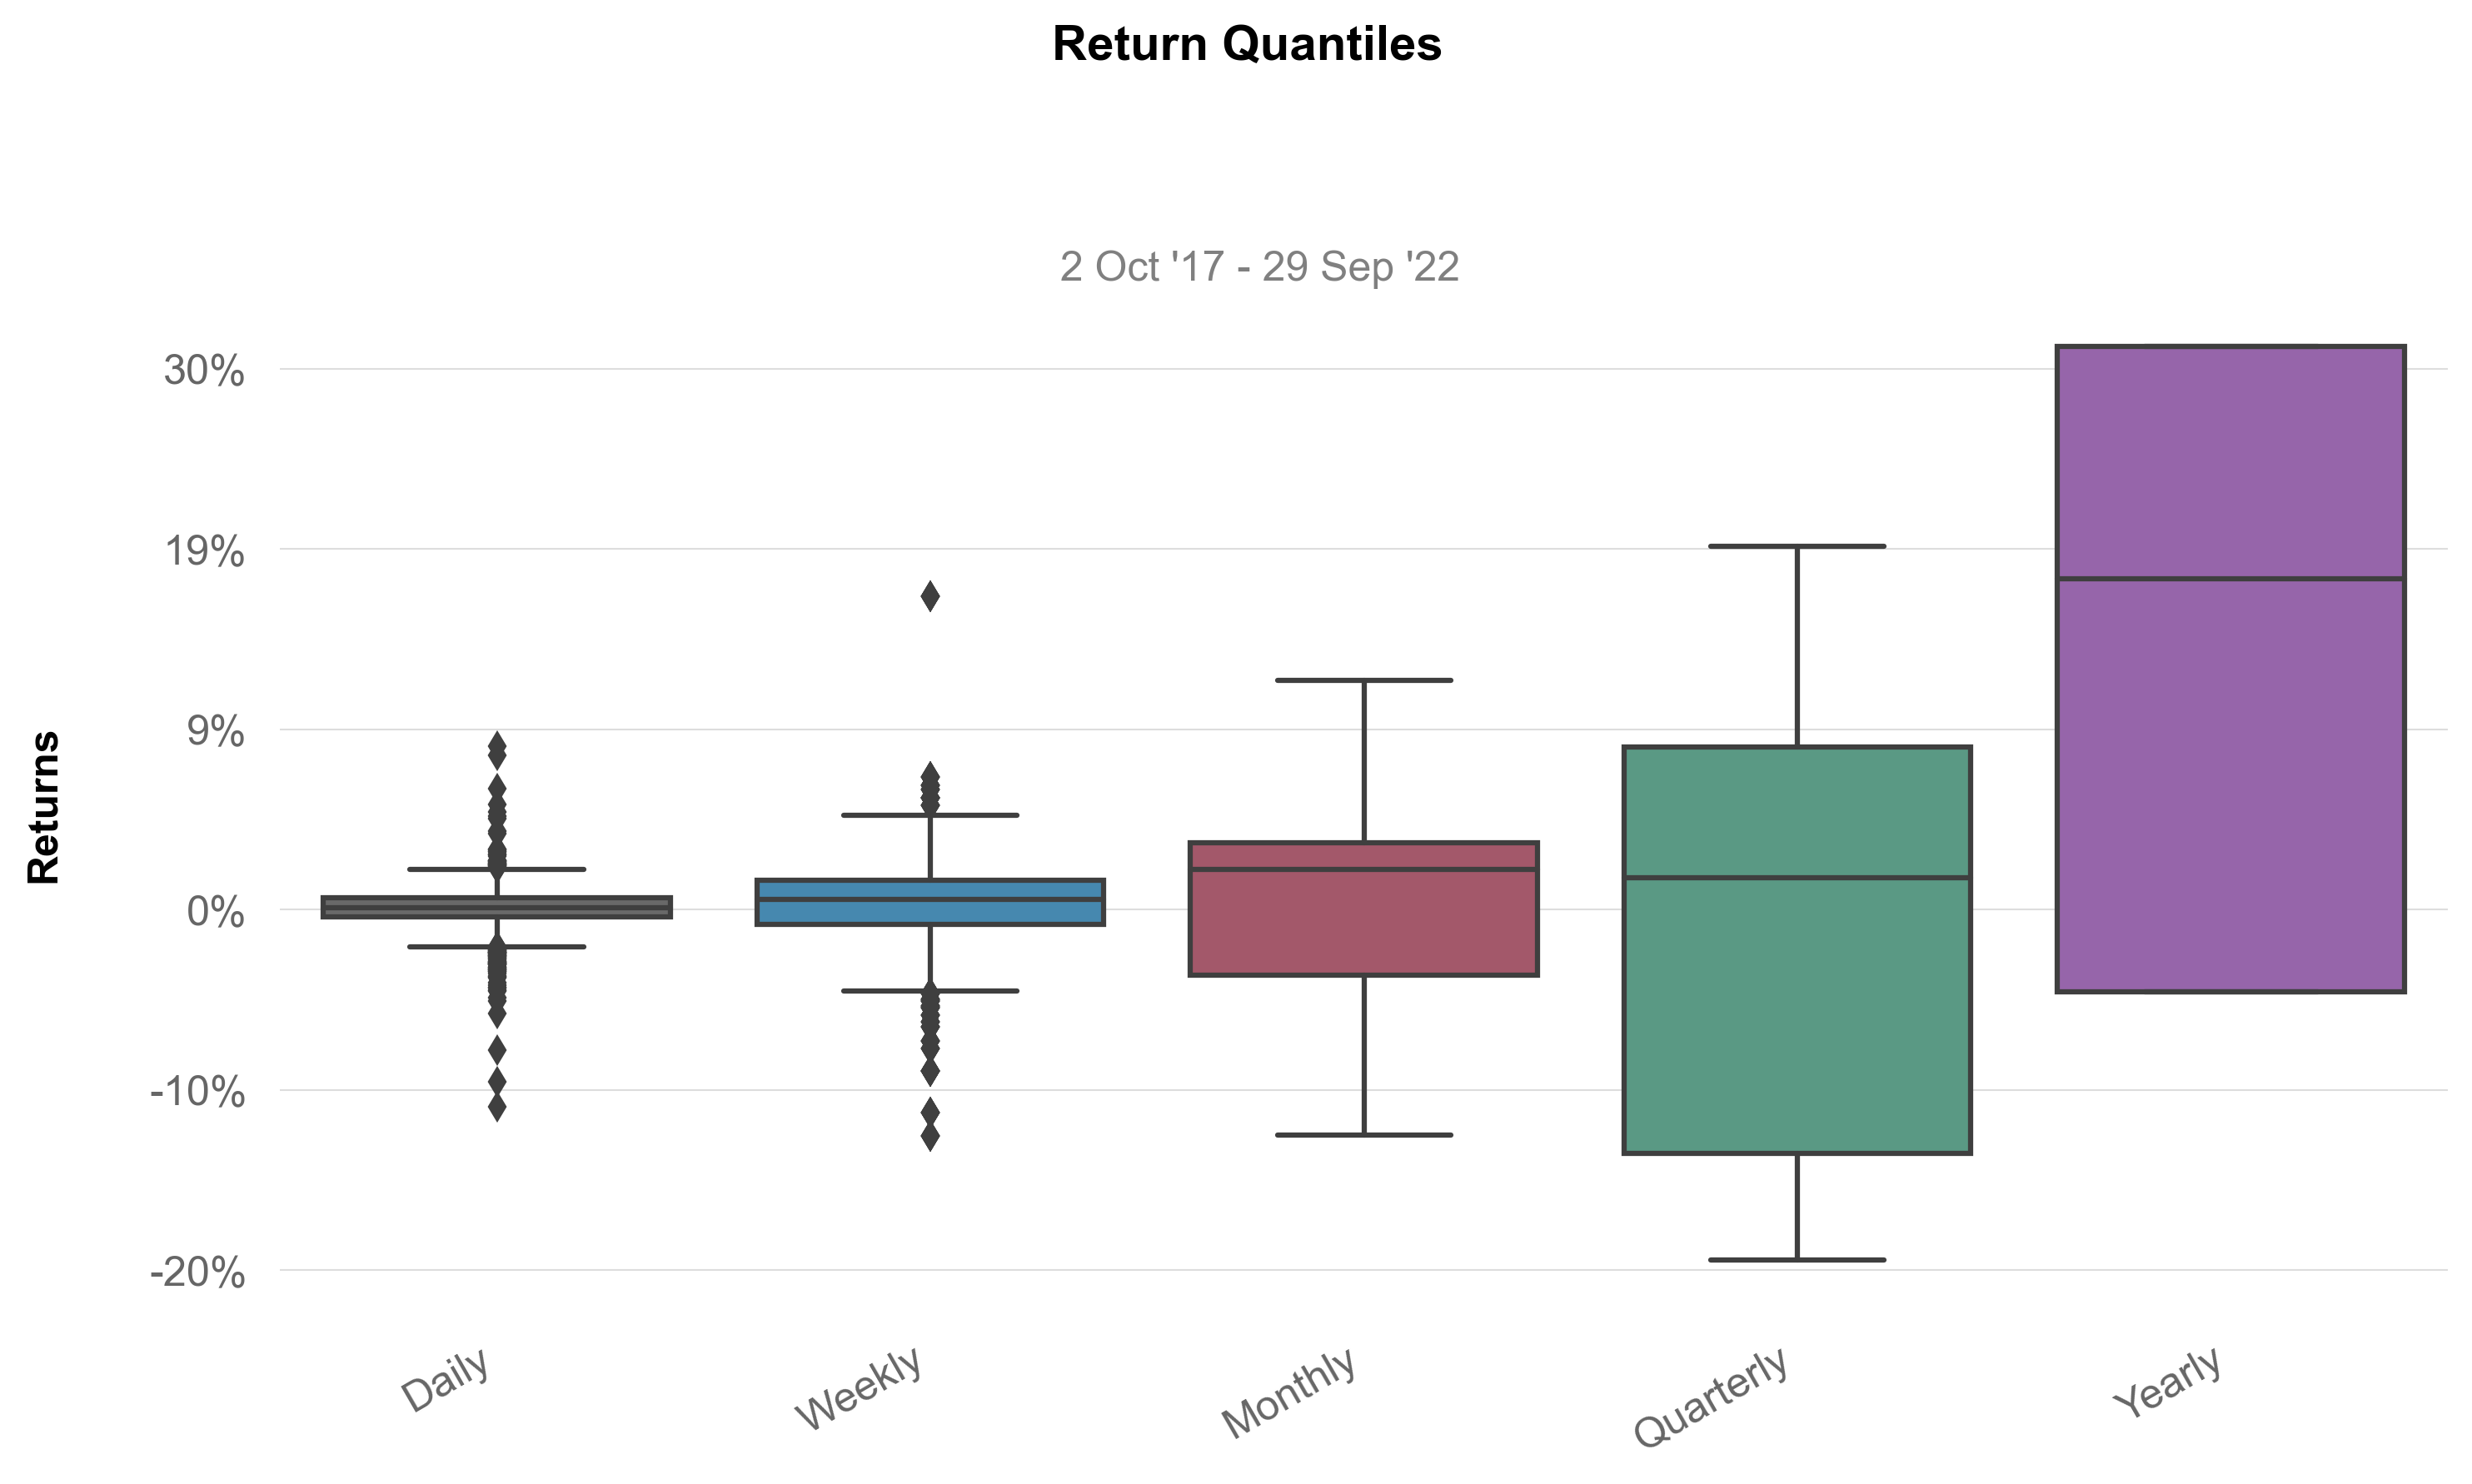

In [ ]:
#| eval: false
values = _utils.download_returns('SPY', '5y')
distribution(values)

In [ ]:
#| export
def histogram(returns, resample='M', fontname='Arial',
              grayscale=False, figsize=(10, 5), ylabel=True,
              subtitle=True, compounded=True, savefig=None, show=True,
              prepare_returns=True):

    if prepare_returns:
        returns = _utils.prepare_returns(returns)

    if resample == 'W':
        title = "Weekly "
    elif resample == 'M':
        title = "Monthly "
    elif resample == 'Q':
        title = "Quarterly "
    elif resample == 'A':
        title = "Annual "
    else:
        title = ""

    return _core.plot_histogram(returns,
                                resample=resample,
                                grayscale=grayscale,
                                fontname=fontname,
                                title="Distribution of %sReturns" % title,
                                figsize=figsize,
                                ylabel=ylabel,
                                subtitle=subtitle,
                                compounded=compounded,
                                savefig=savefig, show=show)

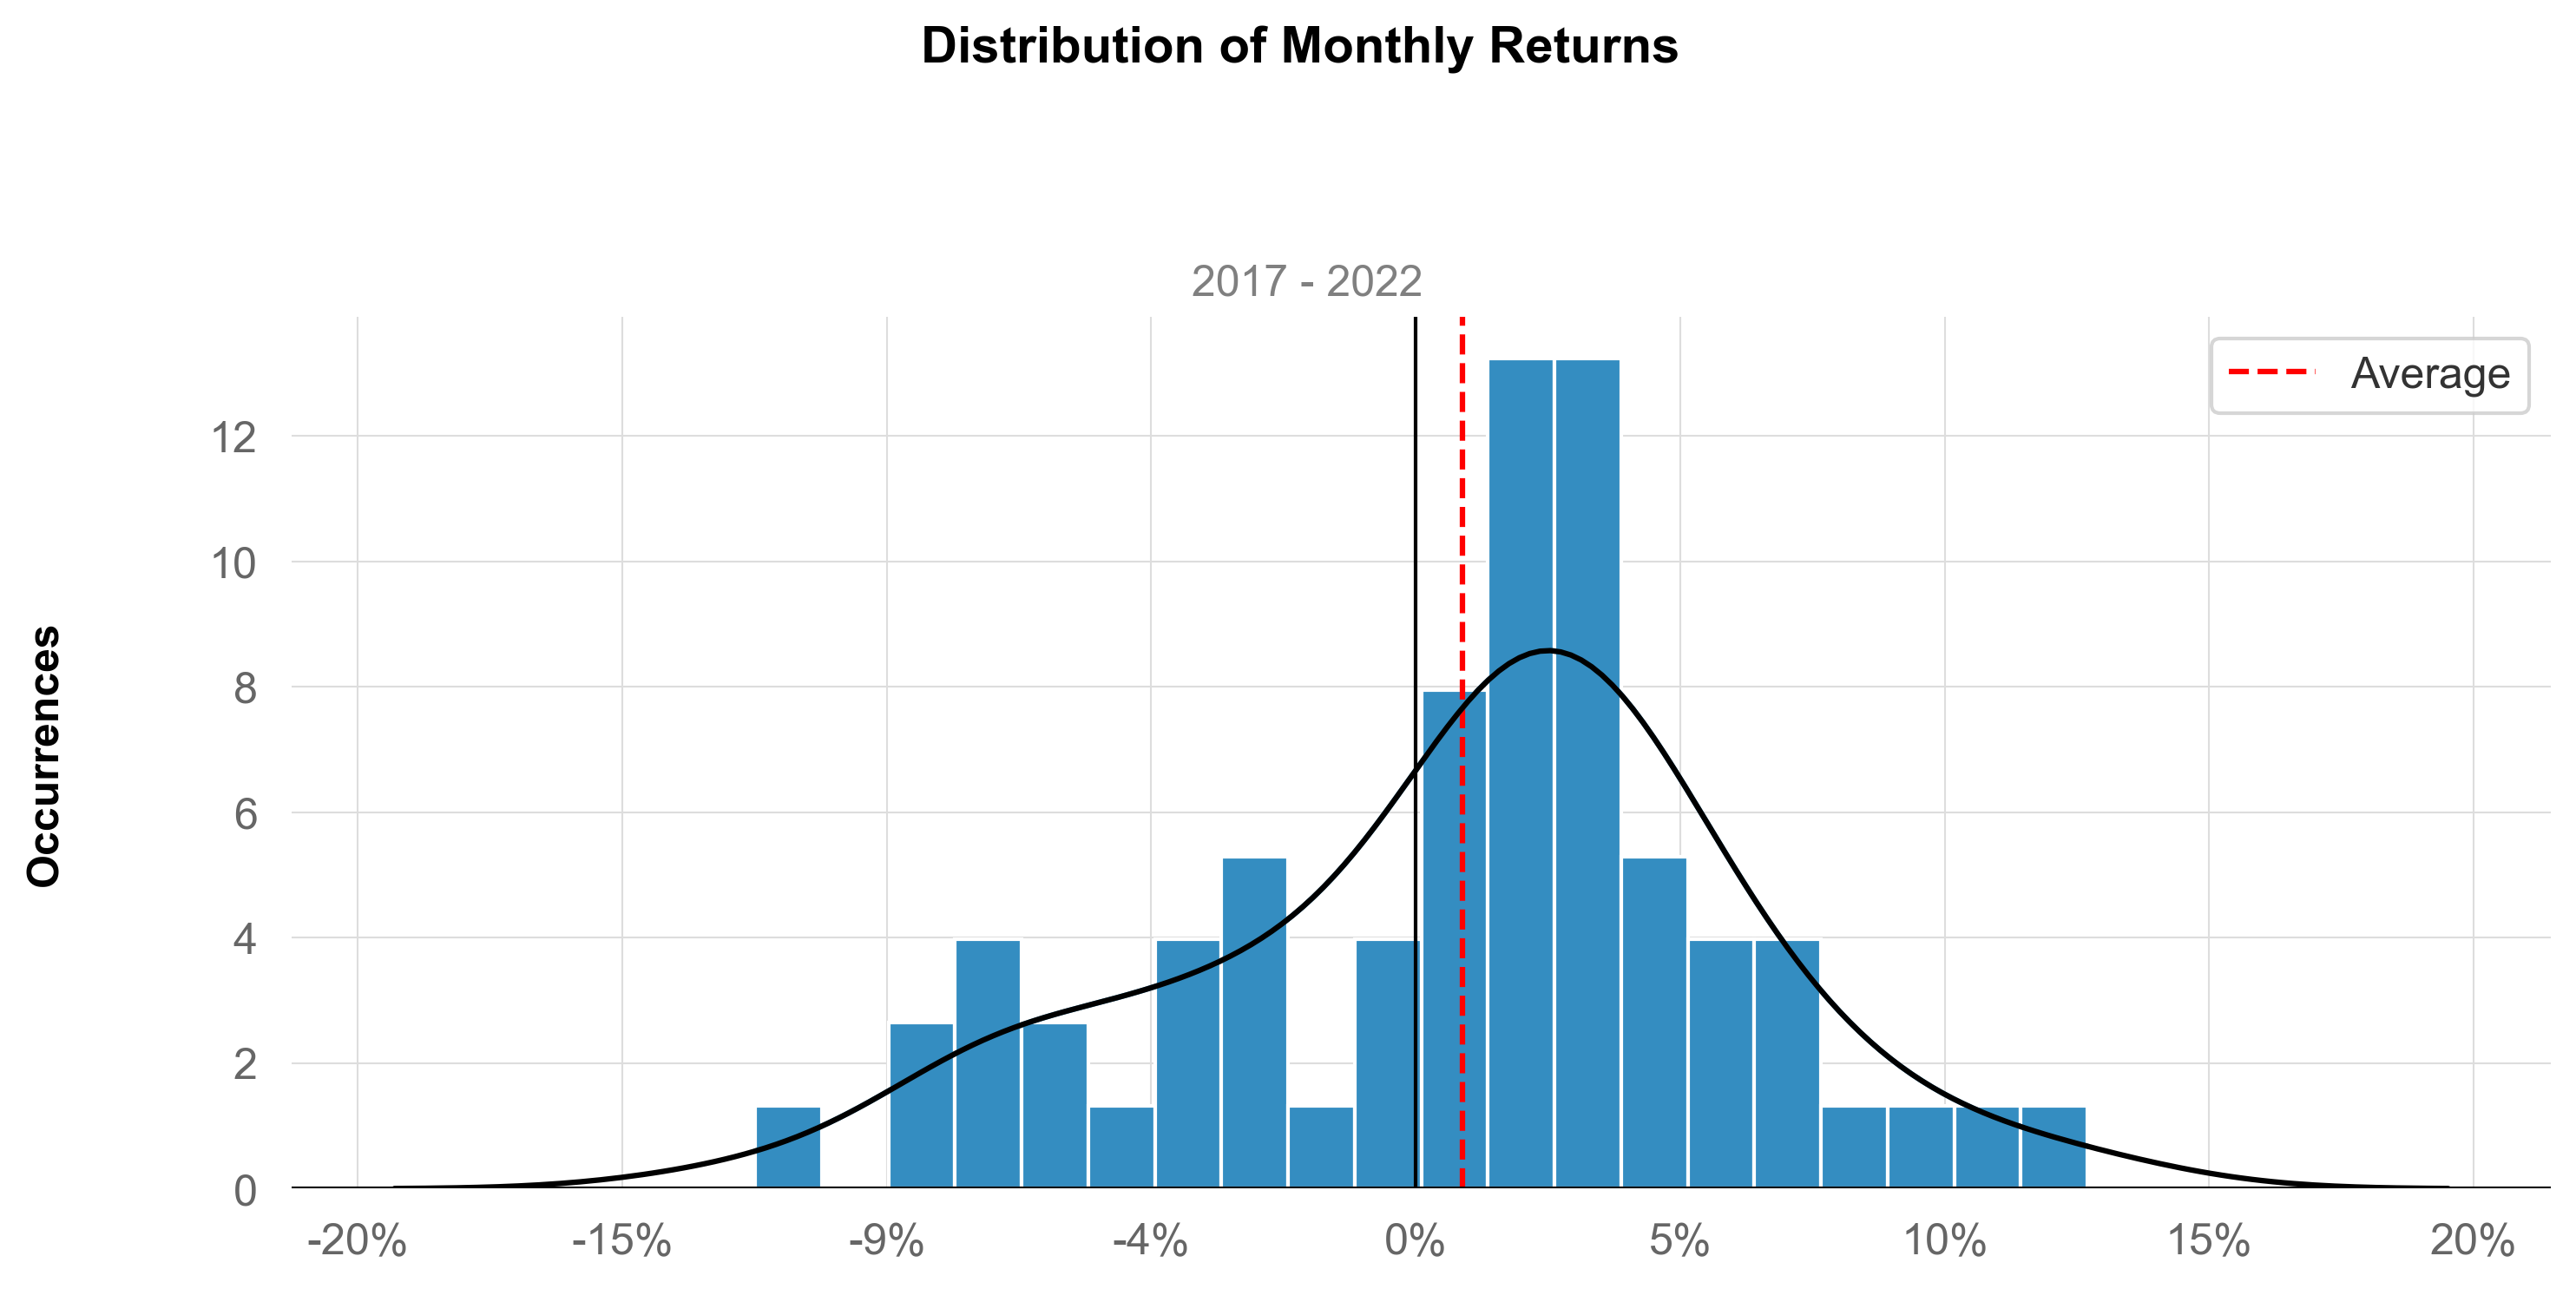

In [ ]:
#| eval: false
values = _utils.download_returns('SPY', '5y')
histogram(values)

In [ ]:
#| export
def drawdown(returns, grayscale=False, figsize=(10, 3),
             fontname='Arial', lw=1, log_scale=False,
             match_volatility=False, compound=False, ylabel="Drawdown",
             resample=None, subtitle=True, savefig=None, show=True):

    dd = _stats.to_drawdown_series(returns)

    fig = _core.plot_timeseries(dd, title='Underwater Plot',
                                hline=dd.mean(), hlw=2, hllabel="Average",
                                returns_label="Drawdown",
                                compound=compound, match_volatility=match_volatility,
                                log_scale=log_scale, resample=resample,
                                fill=True, lw=lw, figsize=figsize,
                                ylabel=ylabel,
                                fontname=fontname, grayscale=grayscale,
                                subtitle=subtitle,
                                savefig=savefig, show=show)
    if not show:
        return fig

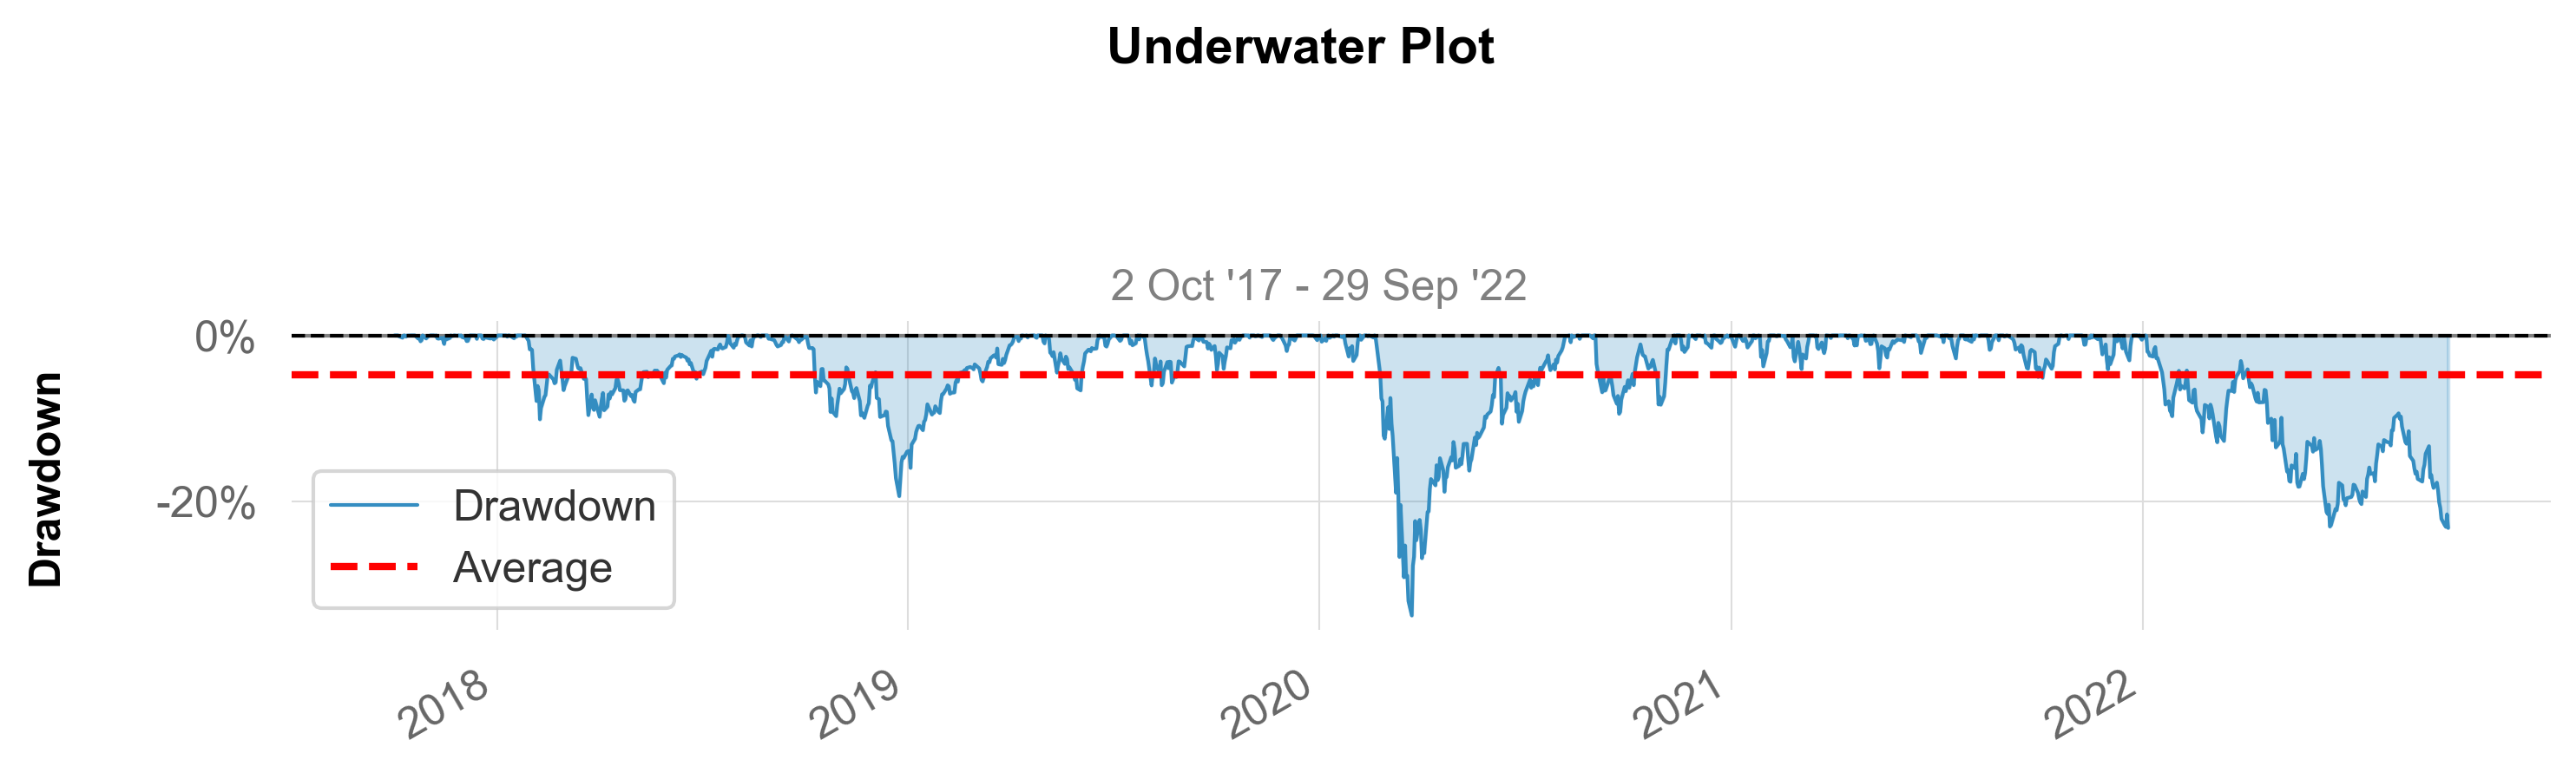

In [ ]:
#| eval: false
values = _utils.download_returns('SPY', '5y')
drawdown(values)

In [ ]:
#| export
def drawdowns_periods(returns, periods=5, lw=1.5, log_scale=False,
                      fontname='Arial', grayscale=False, figsize=(10, 5),
                      ylabel=True, subtitle=True, compounded=True,
                      savefig=None, show=True,
                      prepare_returns=True):
    if prepare_returns:
        returns = _utils.prepare_returns(returns)

    fig = _core.plot_longest_drawdowns(returns,
                                       periods=periods,
                                       lw=lw,
                                       log_scale=log_scale,
                                       fontname=fontname,
                                       grayscale=grayscale,
                                       figsize=figsize,
                                       ylabel=ylabel,
                                       subtitle=subtitle,
                                       compounded=compounded,
                                       savefig=savefig, show=show)
    if not show:
        return fig

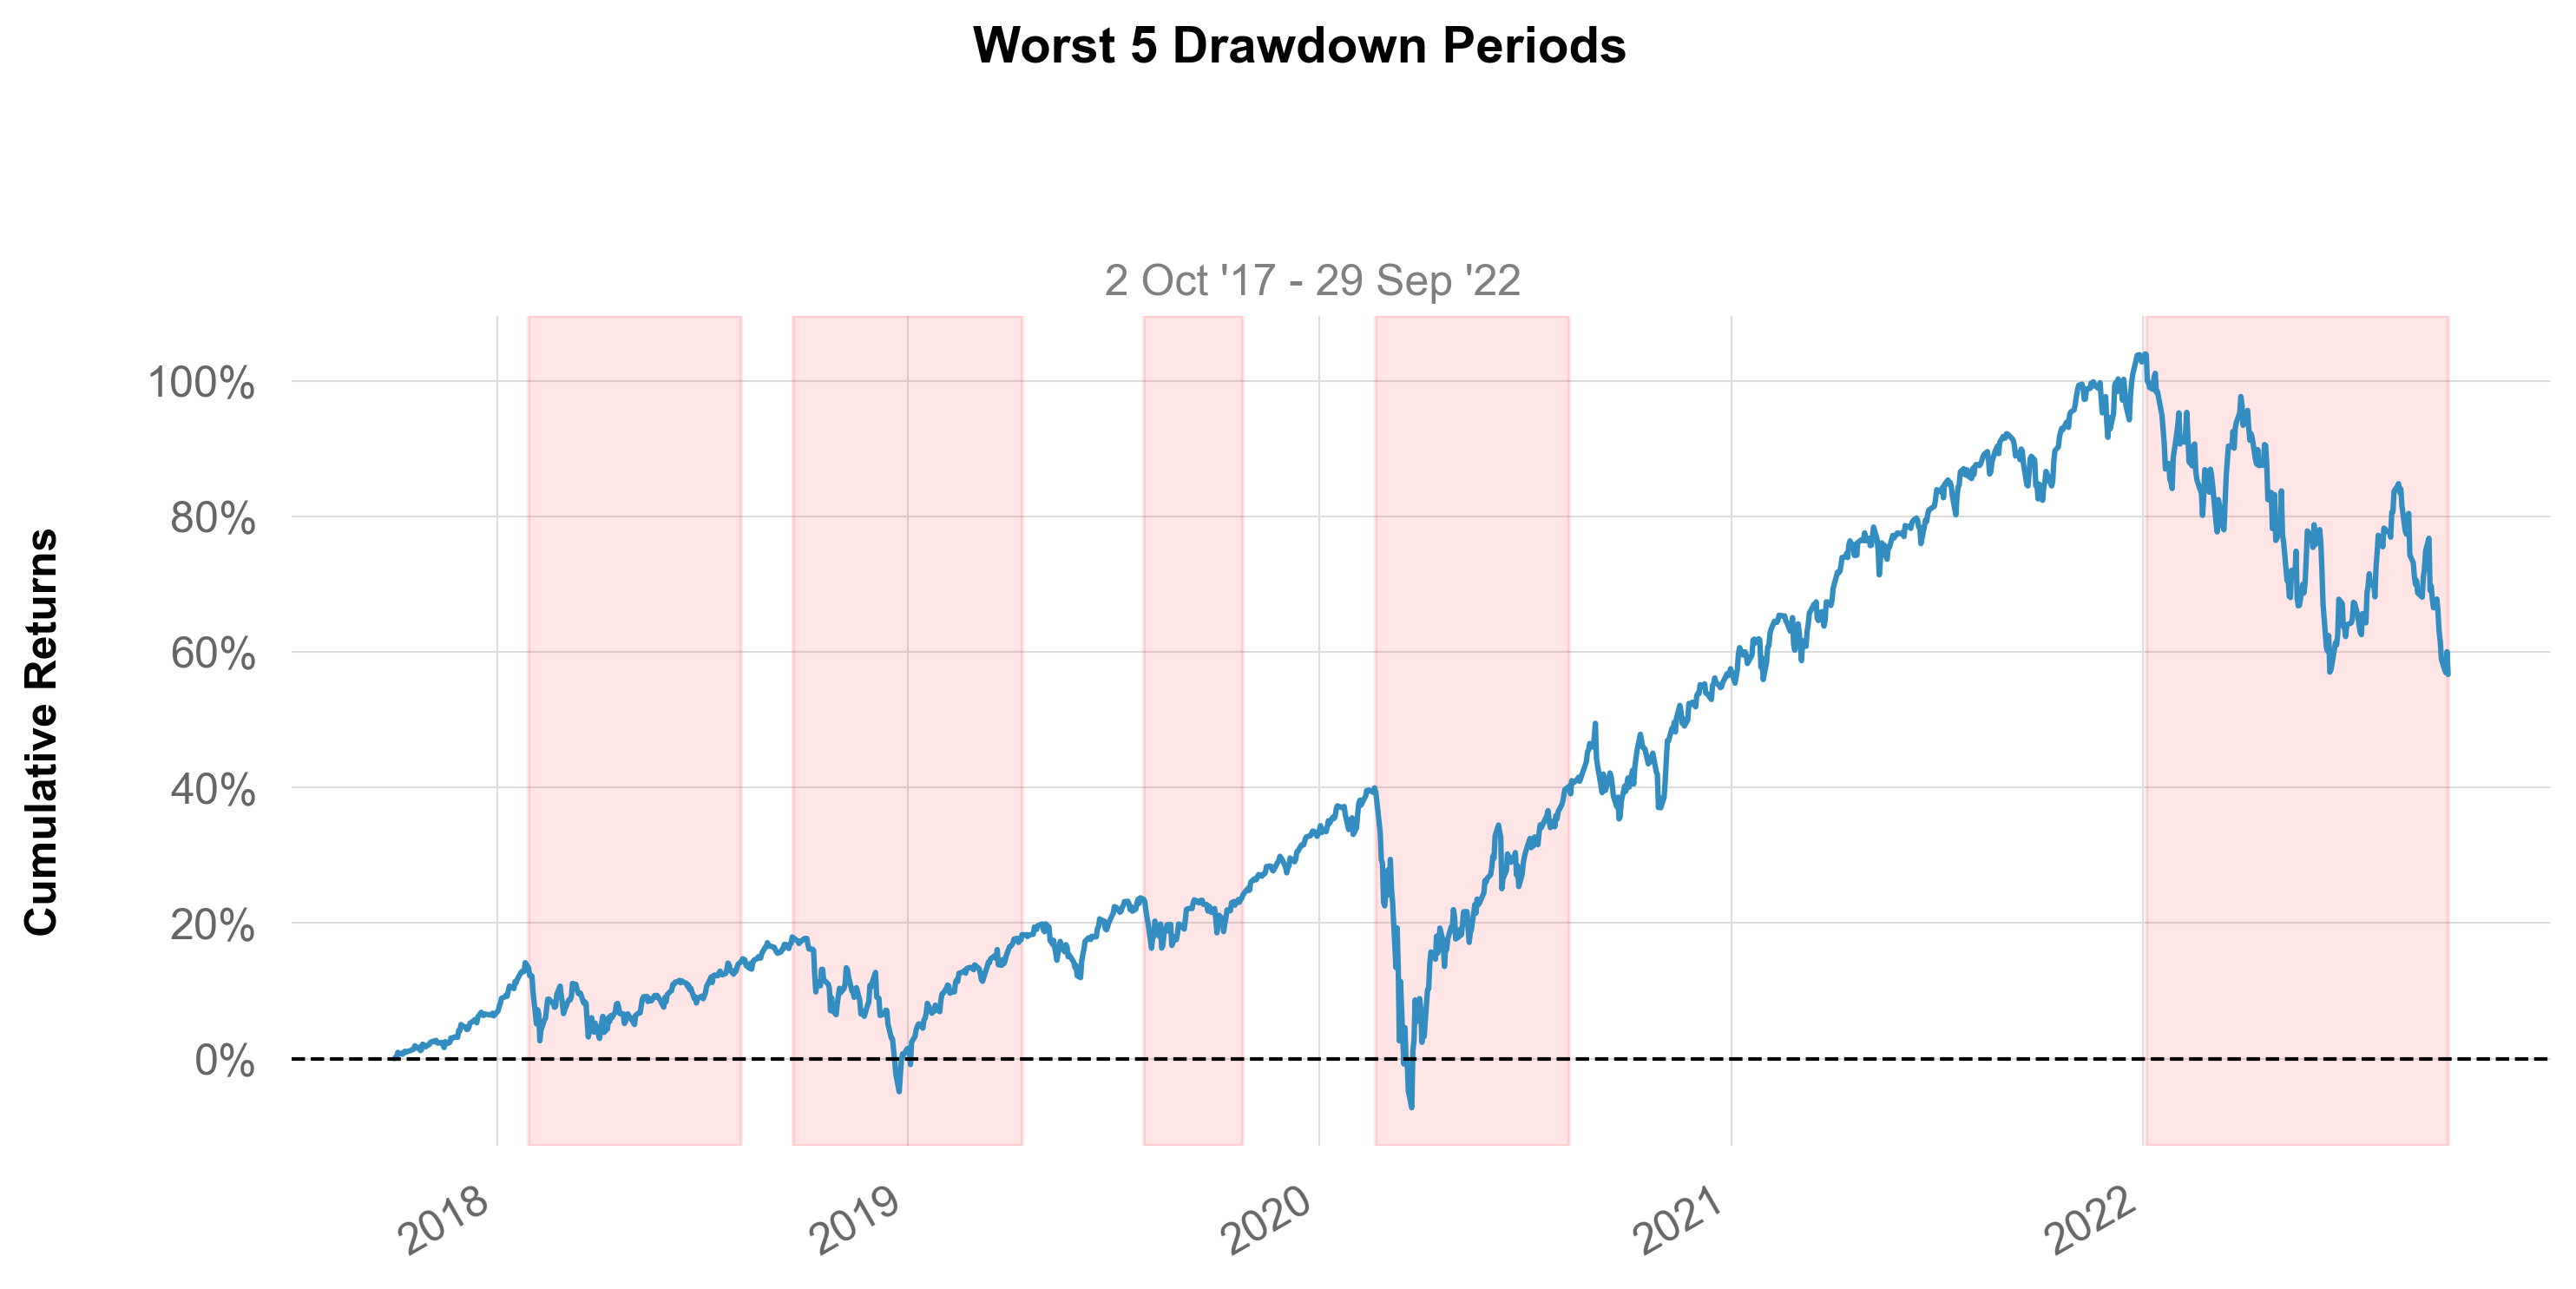

In [ ]:
#| eval: false
values = _utils.download_returns('SPY', '5y')
drawdowns_periods(values)

In [ ]:
#| export
def rolling_beta(returns, benchmark,
                 benchmark_label="Benchmark",
                 window1=126, window1_label="6-Months",
                 window2=252, window2_label="12-Months",
                 lw=1.5, fontname='Arial', grayscale=False,
                 figsize=(10, 3), ylabel=True,
                 subtitle=True, savefig=None, show=True,
                 prepare_returns=True):

    if prepare_returns:
        returns = _utils.prepare_returns(returns)

    benchmark = _utils.prepare_benchmark(benchmark, returns.index)

    fig = _core.plot_rolling_beta(returns, benchmark,
                                  window1=window1, window1_label=window1_label,
                                  window2=window2, window2_label=window2_label,
                                  title="Rolling Beta to %s" % benchmark_label, 
                                  fontname=fontname,
                                  grayscale=grayscale,
                                  lw=lw,
                                  figsize=figsize,
                                  ylabel=ylabel,
                                  subtitle=subtitle,
                                  savefig=savefig, show=show)
    if not show:
        return fig

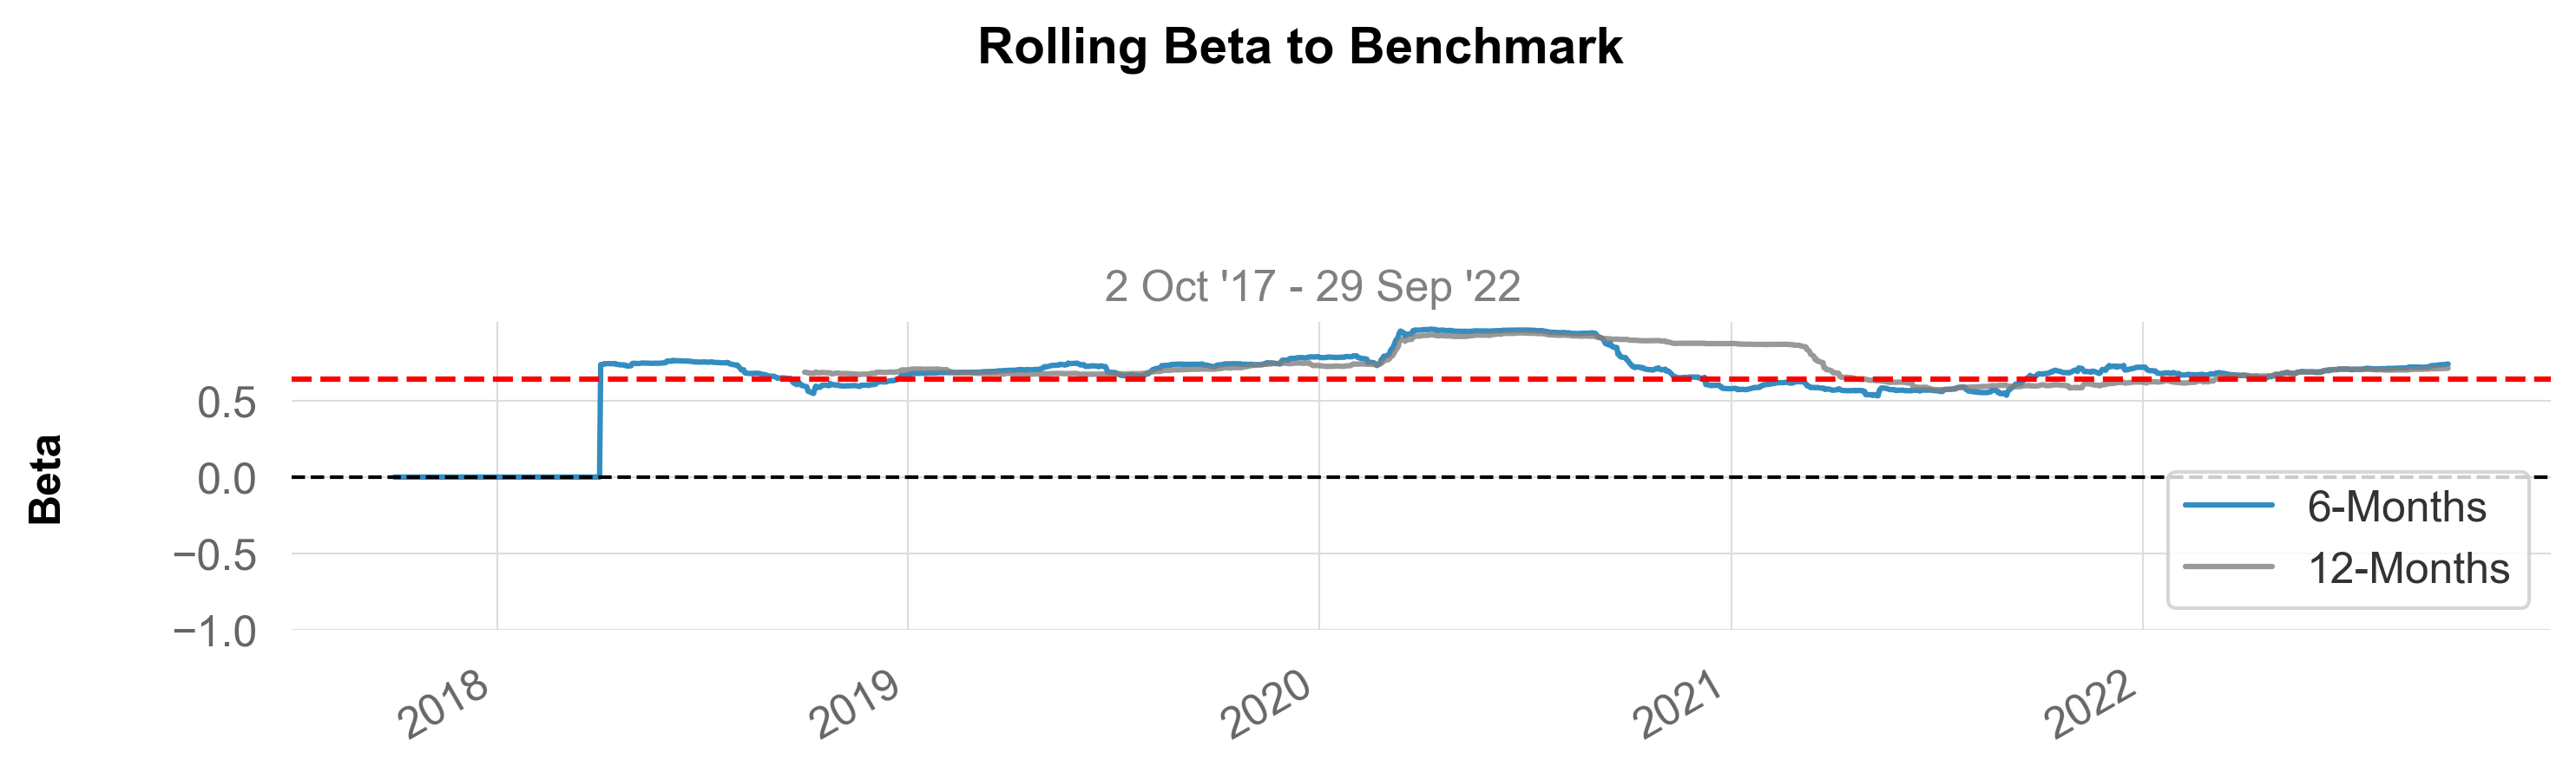

In [ ]:
#| eval: false
values = _utils.download_returns('SPY', '5y')
benchmark = _utils.download_returns('QQQ', '5y')
rolling_beta(values, benchmark)

In [ ]:
#| export
def rolling_volatility(returns, benchmark=None,
                       returns_label="Strategy", benchmark_label="Benchmark",
                       period=126, period_label="6-Months",
                       periods_per_year=252,
                       lw=1.5, fontname='Arial', grayscale=False,
                       figsize=(10, 3), ylabel="Volatility",
                       subtitle=True, savefig=None, show=True):

    returns = _stats.rolling_volatility(returns, period, periods_per_year)

    if benchmark is not None:
        benchmark = _utils.prepare_benchmark(benchmark, returns.index)
        benchmark = _stats.rolling_volatility(
            benchmark, period, periods_per_year, prepare_returns=False)

    fig = _core.plot_rolling_stats(returns, benchmark,
                                   hline=returns.mean(),
                                   hlw=1.5,
                                   ylabel=ylabel,
                                   title='Rolling Volatility (%s)' % period_label,
                                   returns_label=returns_label,
                                   benchmark_label = benchmark_label,
                                   fontname=fontname,
                                   grayscale=grayscale,
                                   lw=lw,
                                   figsize=figsize,
                                   subtitle=subtitle,
                                   savefig=savefig, show=show)
    if not show:
        return fig


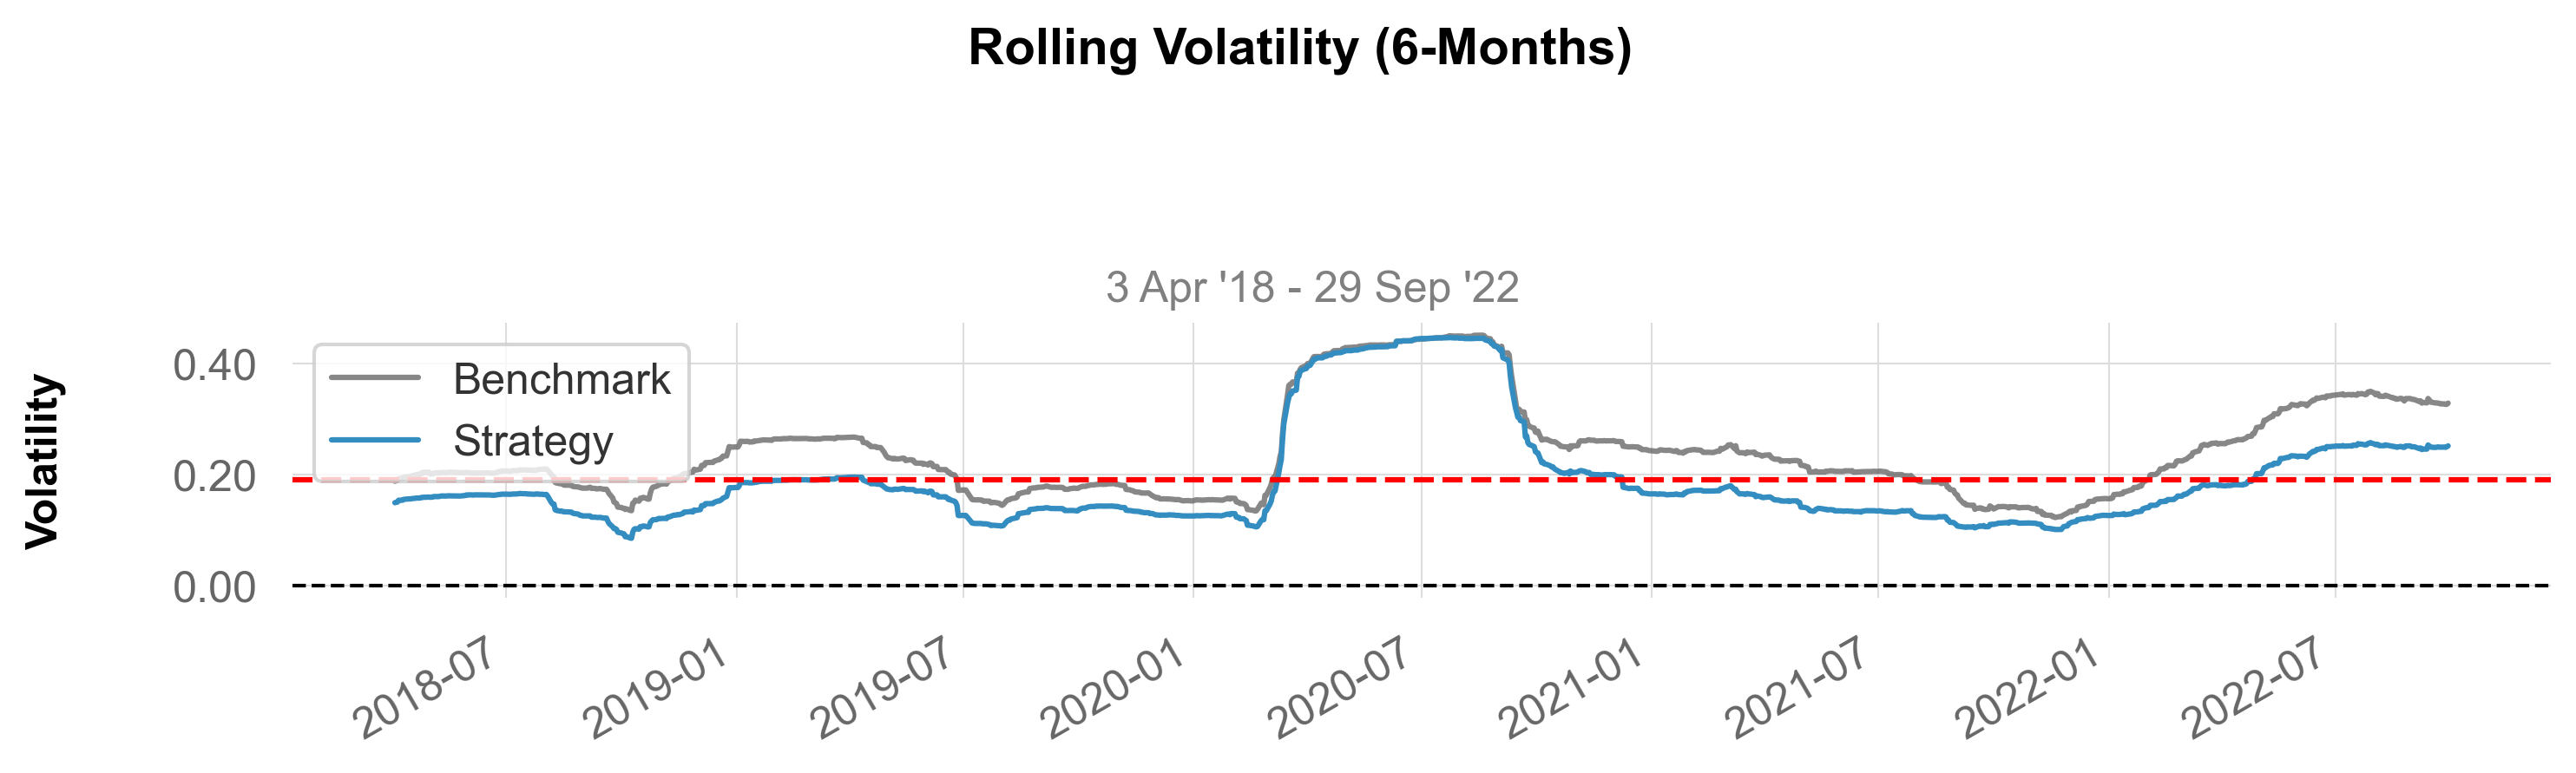

In [ ]:
#| eval: false
values = _utils.download_returns('SPY', '5y')
benchmark = _utils.download_returns('QQQ', '5y')
rolling_volatility(values, benchmark)

In [ ]:
#| export
def rolling_sharpe(returns, benchmark=None, rf=0.,
                   returns_label="Strategy", benchmark_label="Benchmark",
                   period=126, period_label="6-Months",
                   periods_per_year=252,
                   lw=1.25, fontname='Arial', grayscale=False,
                   figsize=(10, 3), ylabel="Sharpe",
                   subtitle=True, savefig=None, show=True):

    returns = _stats.rolling_sharpe(
        returns, rf, period, True, periods_per_year, )

    if benchmark is not None:
        benchmark = _utils.prepare_benchmark(benchmark, returns.index, rf)
        benchmark = _stats.rolling_sharpe(
            benchmark, rf, period, True, periods_per_year,
            prepare_returns=False)

    fig = _core.plot_rolling_stats(returns, benchmark,
                                   hline=returns.mean(),
                                   hlw=1.5,
                                   ylabel=ylabel,
                                   title='Rolling Sharpe (%s)' % period_label,
                                   returns_label=returns_label,
                                   benchmark_label = benchmark_label,
                                   fontname=fontname,
                                   grayscale=grayscale,
                                   lw=lw,
                                   figsize=figsize,
                                   subtitle=subtitle,
                                   savefig=savefig, show=show)
    if not show:
        return fig

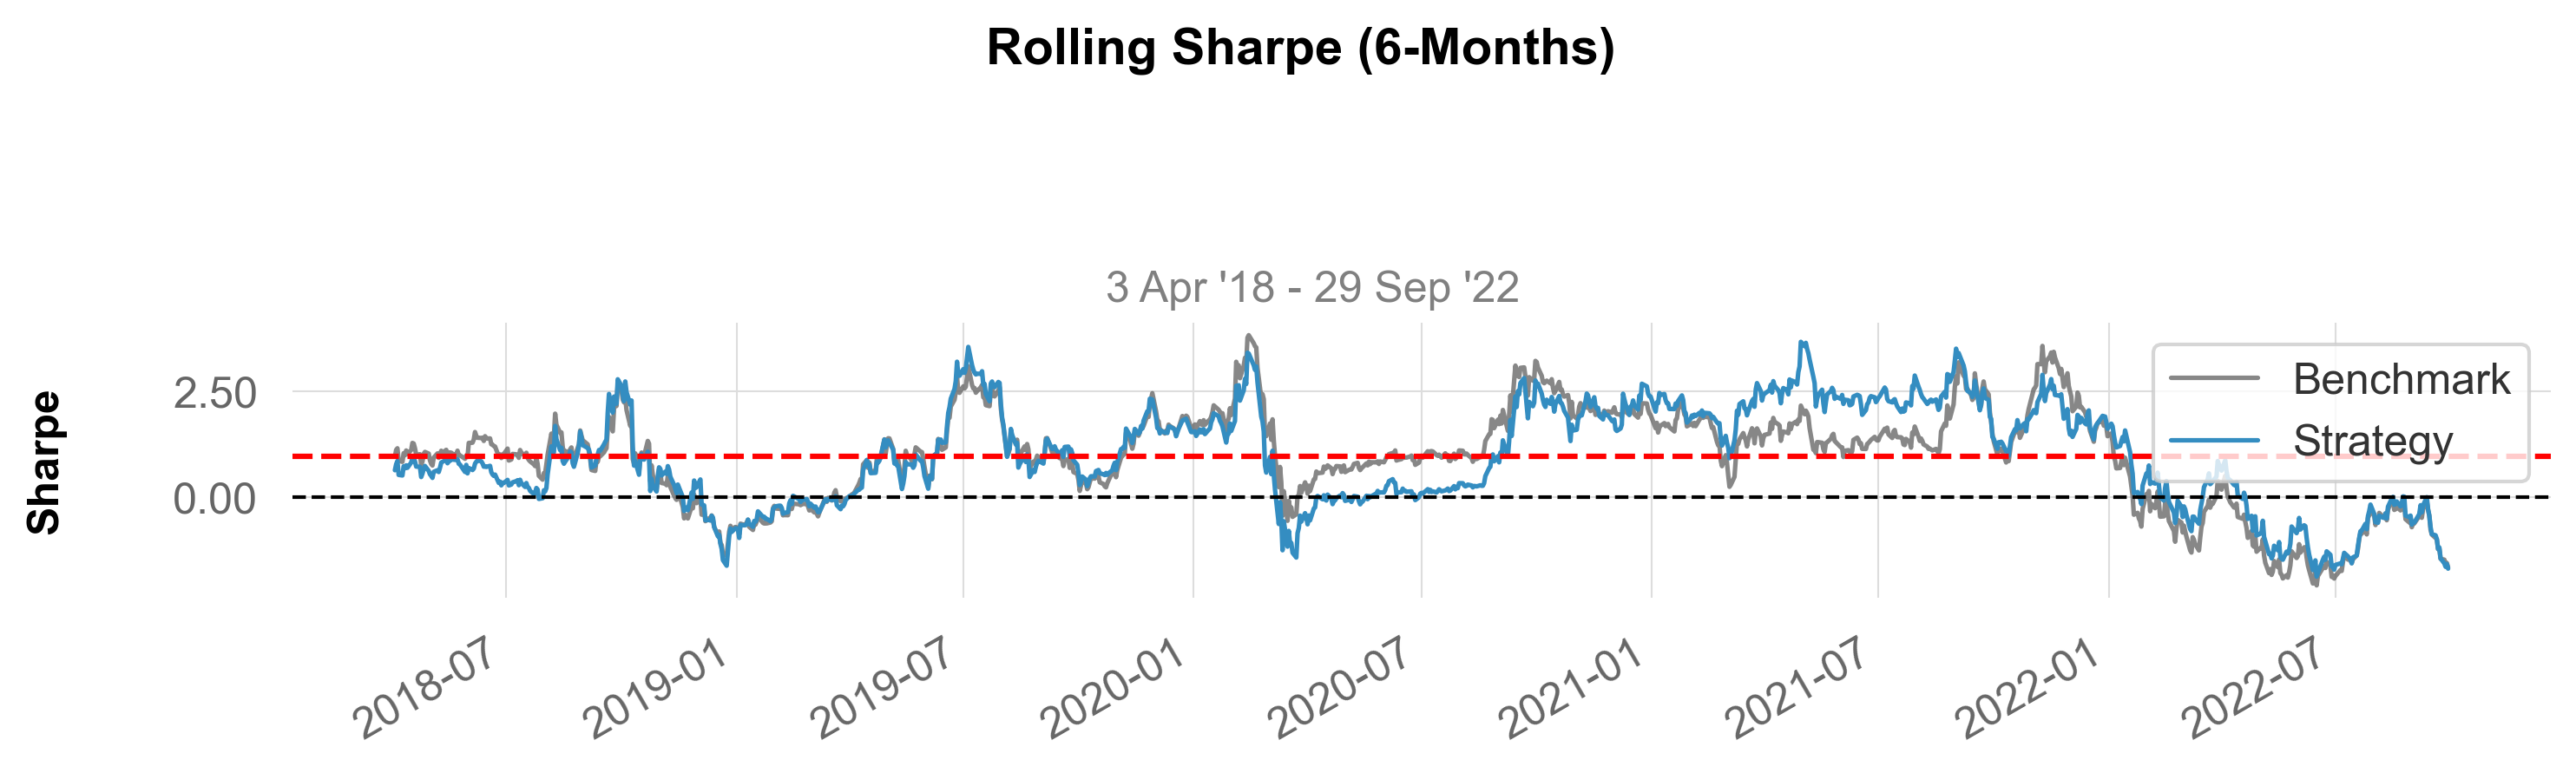

In [ ]:
#| eval: false
values = _utils.download_returns('SPY', '5y')
benchmark = _utils.download_returns('QQQ', '5y')
rolling_sharpe(values, benchmark)

In [ ]:
#| export
def rolling_sortino(returns, benchmark=None, rf=0.,
                    returns_label="Strategy", benchmark_label="Benchmark",
                    period=126, period_label="6-Months",
                    periods_per_year=252,
                    lw=1.25, fontname='Arial', grayscale=False,
                    figsize=(10, 3), ylabel="Sortino",
                    subtitle=True, savefig=None, show=True):

    returns = _stats.rolling_sortino(
        returns, rf, period, True, periods_per_year)

    if benchmark is not None:
        benchmark = _utils.prepare_benchmark(benchmark, returns.index, rf)
        benchmark = _stats.rolling_sortino(
            benchmark, rf, period, True, periods_per_year,
            prepare_returns=False)

    fig = _core.plot_rolling_stats(returns, benchmark,
                                   hline=returns.mean(),
                                   hlw=1.5,
                                   ylabel=ylabel,
                                   title='Rolling Sortino (%s)' % period_label,
                                   returns_label=returns_label,
                                   benchmark_label = benchmark_label,
                                   fontname=fontname,
                                   grayscale=grayscale,
                                   lw=lw,
                                   figsize=figsize,
                                   subtitle=subtitle,
                                   savefig=savefig, show=show)
    if not show:
        return fig

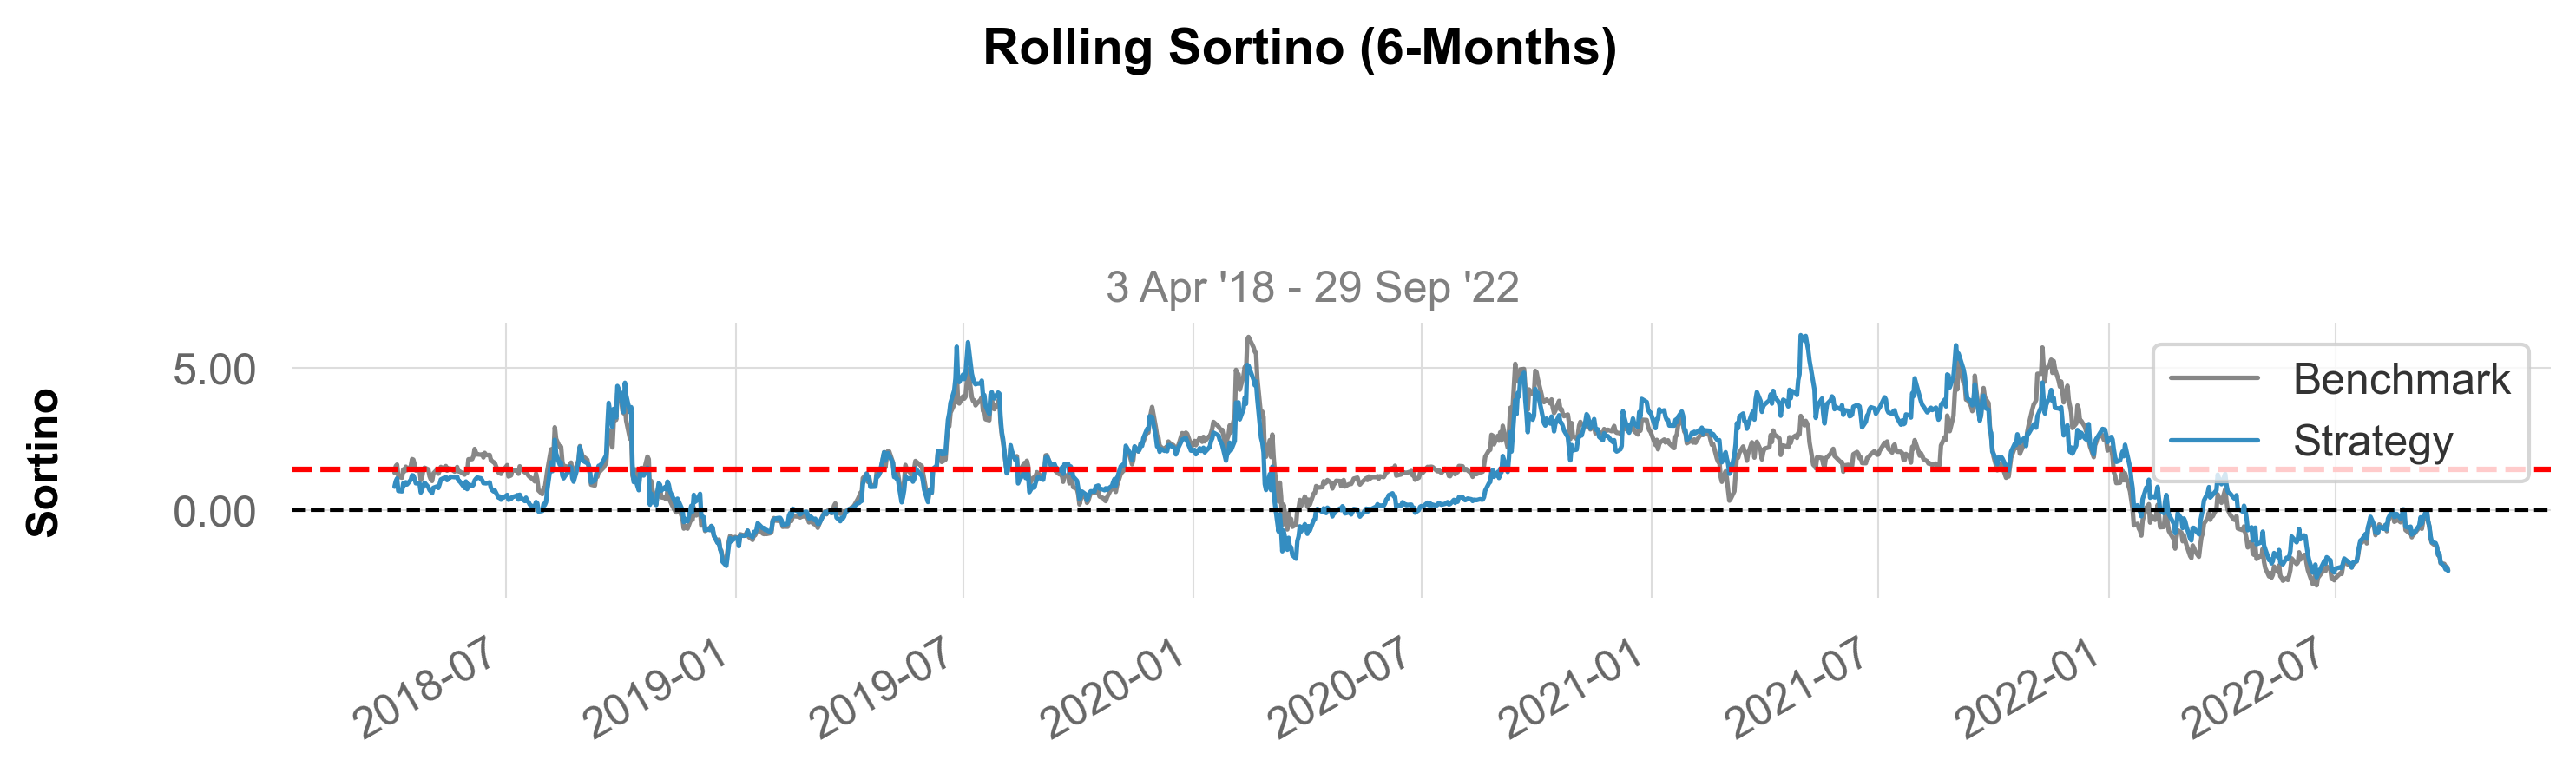

In [ ]:
#| eval: false
values = _utils.download_returns('SPY', '5y')
benchmark = _utils.download_returns('QQQ', '5y')
rolling_sortino(values, benchmark)

In [ ]:
#| export
def monthly_heatmap(returns, annot_size=10, figsize=(10, 5),
                    cbar=True, square=False,
                    compounded=True, eoy=False,
                    grayscale=False, fontname='Arial',
                    ylabel=True, savefig=None, show=True):

    # colors, ls, alpha = _core._get_colors(grayscale)
    cmap = 'gray' if grayscale else 'RdYlGn'
    
    vmax = (_stats.monthly_returns(returns, eoy=False,
                                     compounded=compounded) * 100).abs().max().max()
    
    #if vmax < 1: vmax = 1 ##
    

    returns = _stats.monthly_returns(returns, eoy=eoy,
                                     compounded=compounded) * 100
    
    

    fig_height = len(returns) / 3

    if figsize is None:
        size = list(plt.gcf().get_size_inches())
        figsize = (size[0], size[1])

    figsize = (figsize[0], max([fig_height, figsize[1]]))

    if cbar:
        figsize = (figsize[0]*1.04, max([fig_height, figsize[1]]))

    fig, ax = plt.subplots(figsize=figsize)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    fig.set_facecolor('white')
    ax.set_facecolor('white')

    ax.set_title('      Monthly Returns (%)\n', fontsize=14, y=.995,
                 fontname=fontname, fontweight='bold', color='black')

    # _sns.set(font_scale=.9)
    ax = sns.heatmap(returns, ax=ax, annot=True, center=0,
                      vmax=vmax, #vmin = -vmax,
                      annot_kws={"size": annot_size},
                      fmt="0.2f", linewidths=0.5,
                      square=square, cbar=cbar, cmap=cmap,
                      cbar_kws={'format': '%.0f%%'})
    # _sns.set(font_scale=1)

    # align plot to match other
    if ylabel:
        ax.set_ylabel('Years', fontname=fontname,
                      fontweight='bold', fontsize=12)
        ax.yaxis.set_label_coords(-.1, .5)

    ax.tick_params(colors="#808080")
    plt.xticks(rotation=0, fontsize=annot_size*1.2)
    plt.yticks(rotation=0, fontsize=annot_size*1.2)

    try:
        plt.subplots_adjust(hspace=0, bottom=0, top=1)
    except Exception:
        pass
    try:
        fig.tight_layout(w_pad=0, h_pad=0)
    except Exception:
        pass

    if savefig:
        if isinstance(savefig, dict):
            plt.savefig(**savefig)
        else:
            plt.savefig(savefig)

    if show:
        plt.show(block=False)

    plt.close()

    if not show:
        return fig

    return None

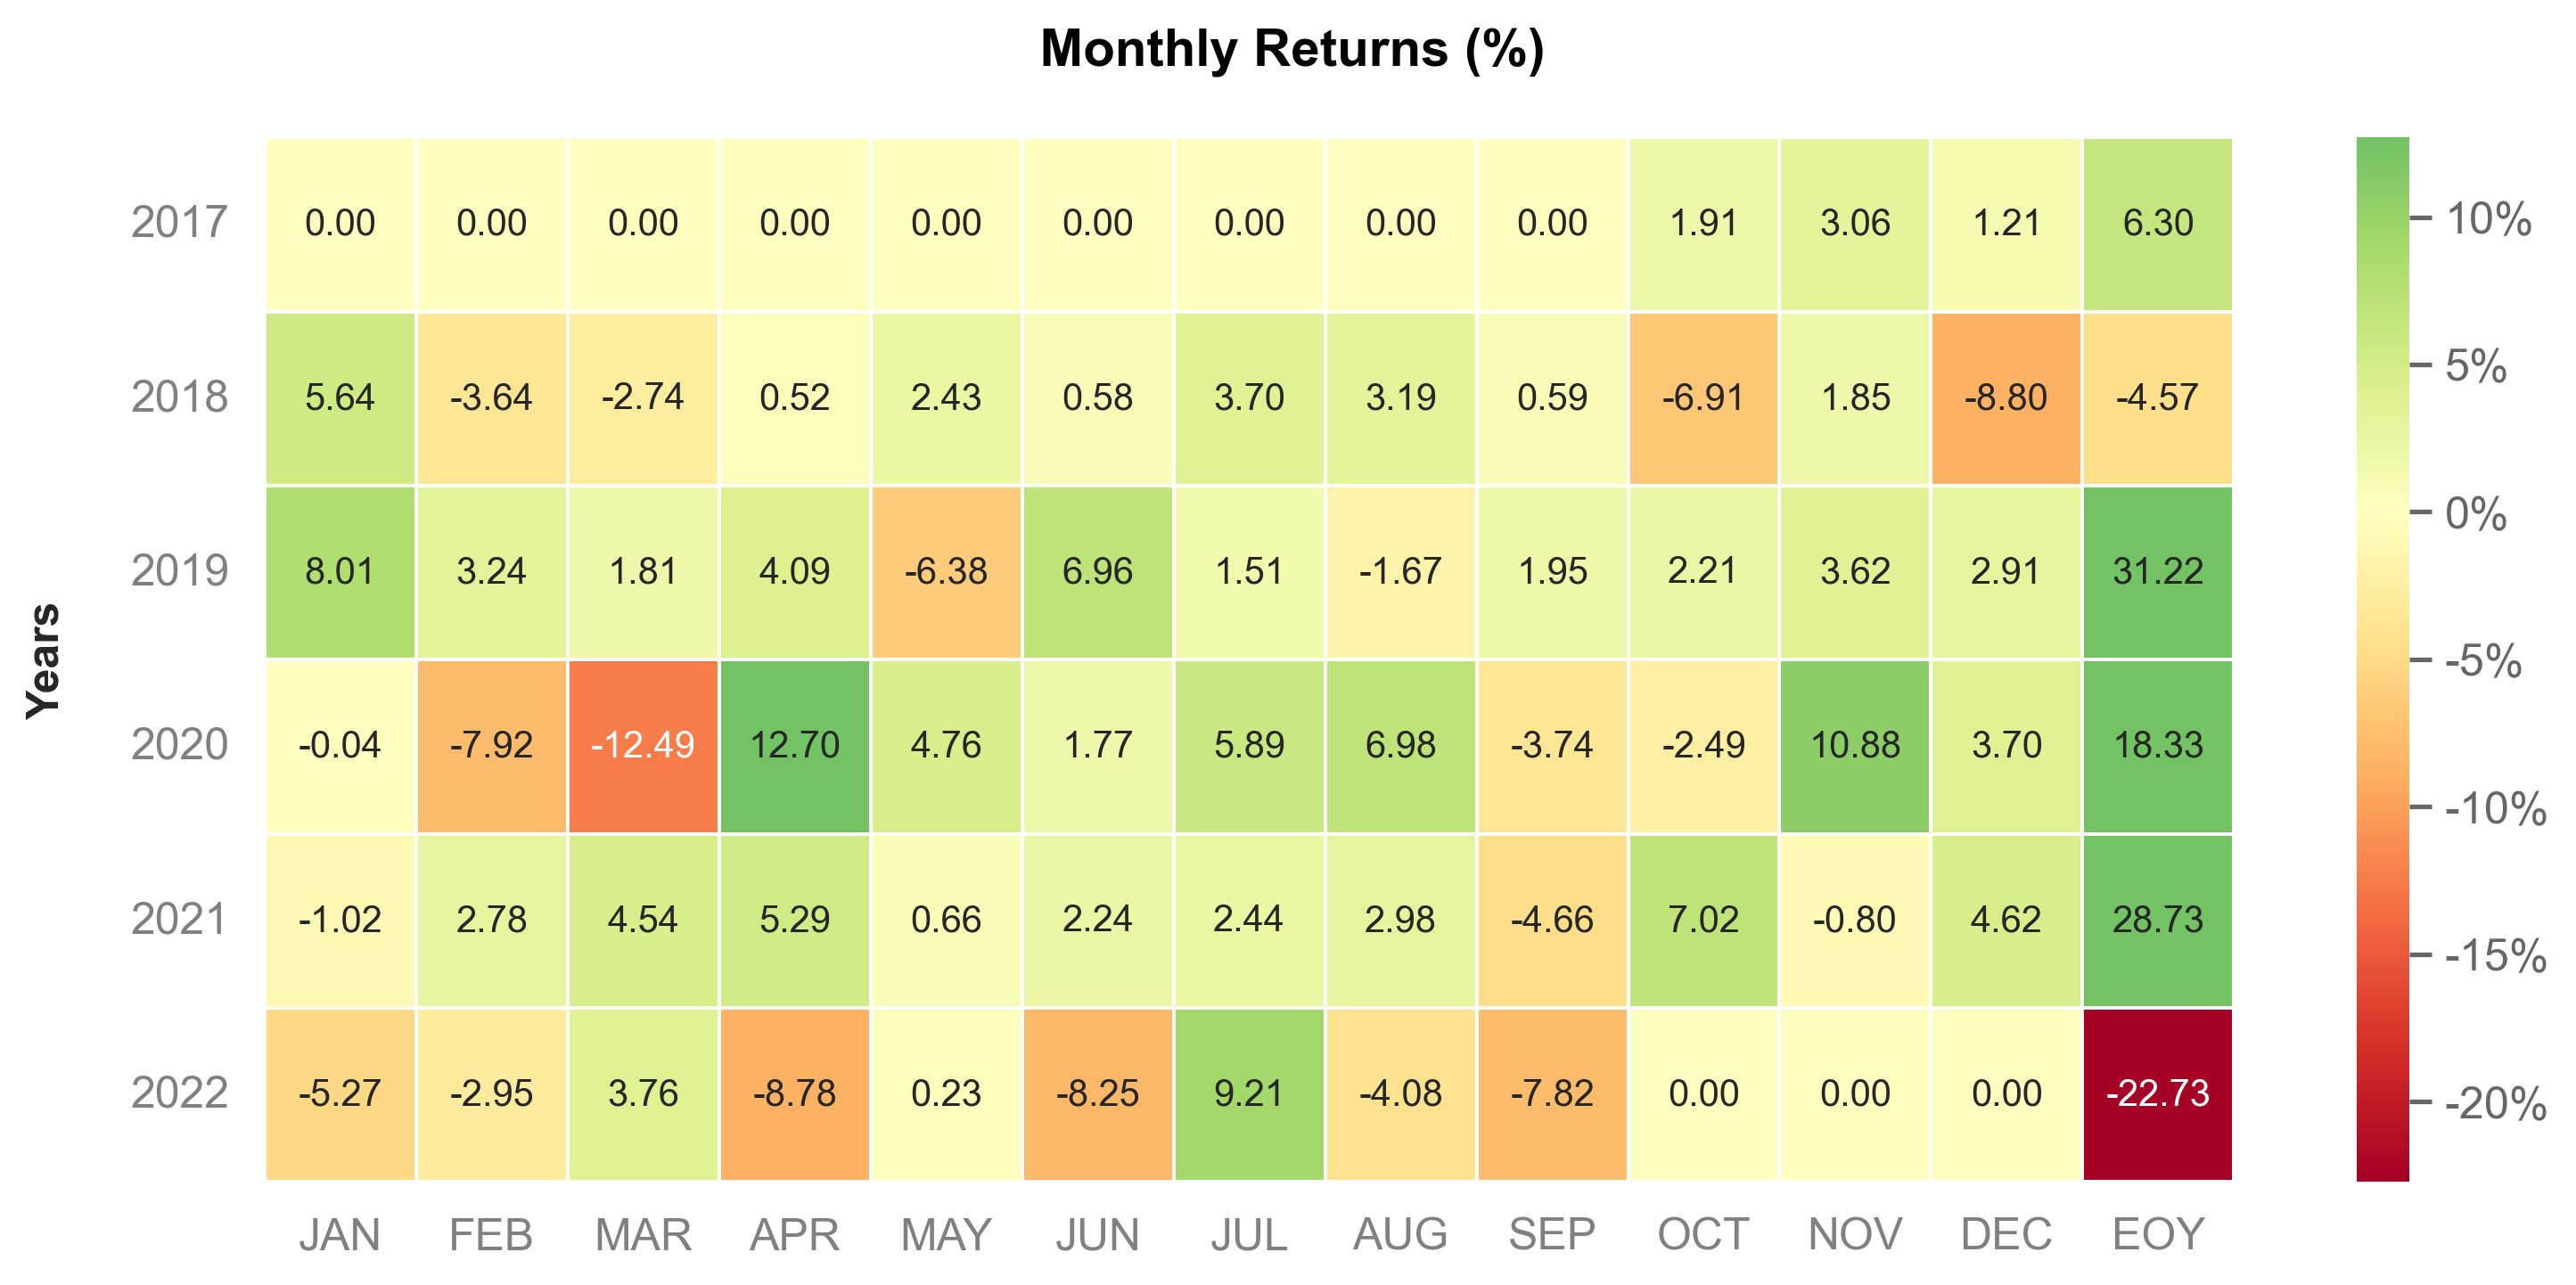

In [ ]:
#| eval: false
values = _utils.download_returns('SPY', '5y')
monthly_heatmap(values, eoy=True)

In [ ]:
#| export
def outperformance_heatmap(returns, benchmark=None, annot_size=10, figsize=(10, 5),
                    cbar=True, square=False, benchmark_label="Benchmark",
                    compounded=True, eoy=False,
                    grayscale=False, fontname='Arial',
                    ylabel=True, savefig=None, show=True):

    # colors, ls, alpha = _core._get_colors(grayscale)
    cmap = 'gray' if grayscale else 'RdYlGn'
    
    vmax = ((
        _stats.monthly_returns(returns, eoy=False,
                                     compounded=compounded)-
        _stats.monthly_returns(benchmark, eoy=False,
                               compounded=compounded)
            )* 100).abs().max().max()
    
    if vmax < 1: vmax = 1 ##
    

    outperformance = ((
        _stats.monthly_returns(returns, eoy=eoy,
                                     compounded=compounded)-
        _stats.monthly_returns(benchmark, eoy=eoy,
                               compounded=compounded)
            )* 100)
    
    

    fig_height = len(outperformance) / 3

    if figsize is None:
        size = list(plt.gcf().get_size_inches())
        figsize = (size[0], size[1])

    figsize = (figsize[0], max([fig_height, figsize[1]]))

    if cbar:
        figsize = (figsize[0]*1.04, max([fig_height, figsize[1]]))

    fig, ax = plt.subplots(figsize=figsize)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    fig.set_facecolor('white')
    ax.set_facecolor('white')

    ax.set_title('      Monthly Outperformance against %s \n' % benchmark_label, fontsize=14, y=.995,
                 fontname=fontname, fontweight='bold', color='black')

    # _sns.set(font_scale=.9)
    ax = sns.heatmap(outperformance, ax=ax, annot=True, center=0,
                      vmax=vmax, #vmin = -vmax,
                      annot_kws={"size": annot_size},
                      fmt="0.2f", linewidths=0.5,
                      square=square, cbar=cbar, cmap=cmap,
                      cbar_kws={'format': '%.0f%%'})
    # _sns.set(font_scale=1)

    # align plot to match other
    if ylabel:
        ax.set_ylabel('Years', fontname=fontname,
                      fontweight='bold', fontsize=12)
        ax.yaxis.set_label_coords(-.1, .5)

    ax.tick_params(colors="#808080")
    plt.xticks(rotation=0, fontsize=annot_size*1.2)
    plt.yticks(rotation=0, fontsize=annot_size*1.2)

    try:
        plt.subplots_adjust(hspace=0, bottom=0, top=1)
    except Exception:
        pass
    try:
        fig.tight_layout(w_pad=0, h_pad=0)
    except Exception:
        pass

    if savefig:
        if isinstance(savefig, dict):
            plt.savefig(**savefig)
        else:
            plt.savefig(savefig)

    if show:
        plt.show(block=False)

    plt.close()

    if not show:
        return fig

    return None

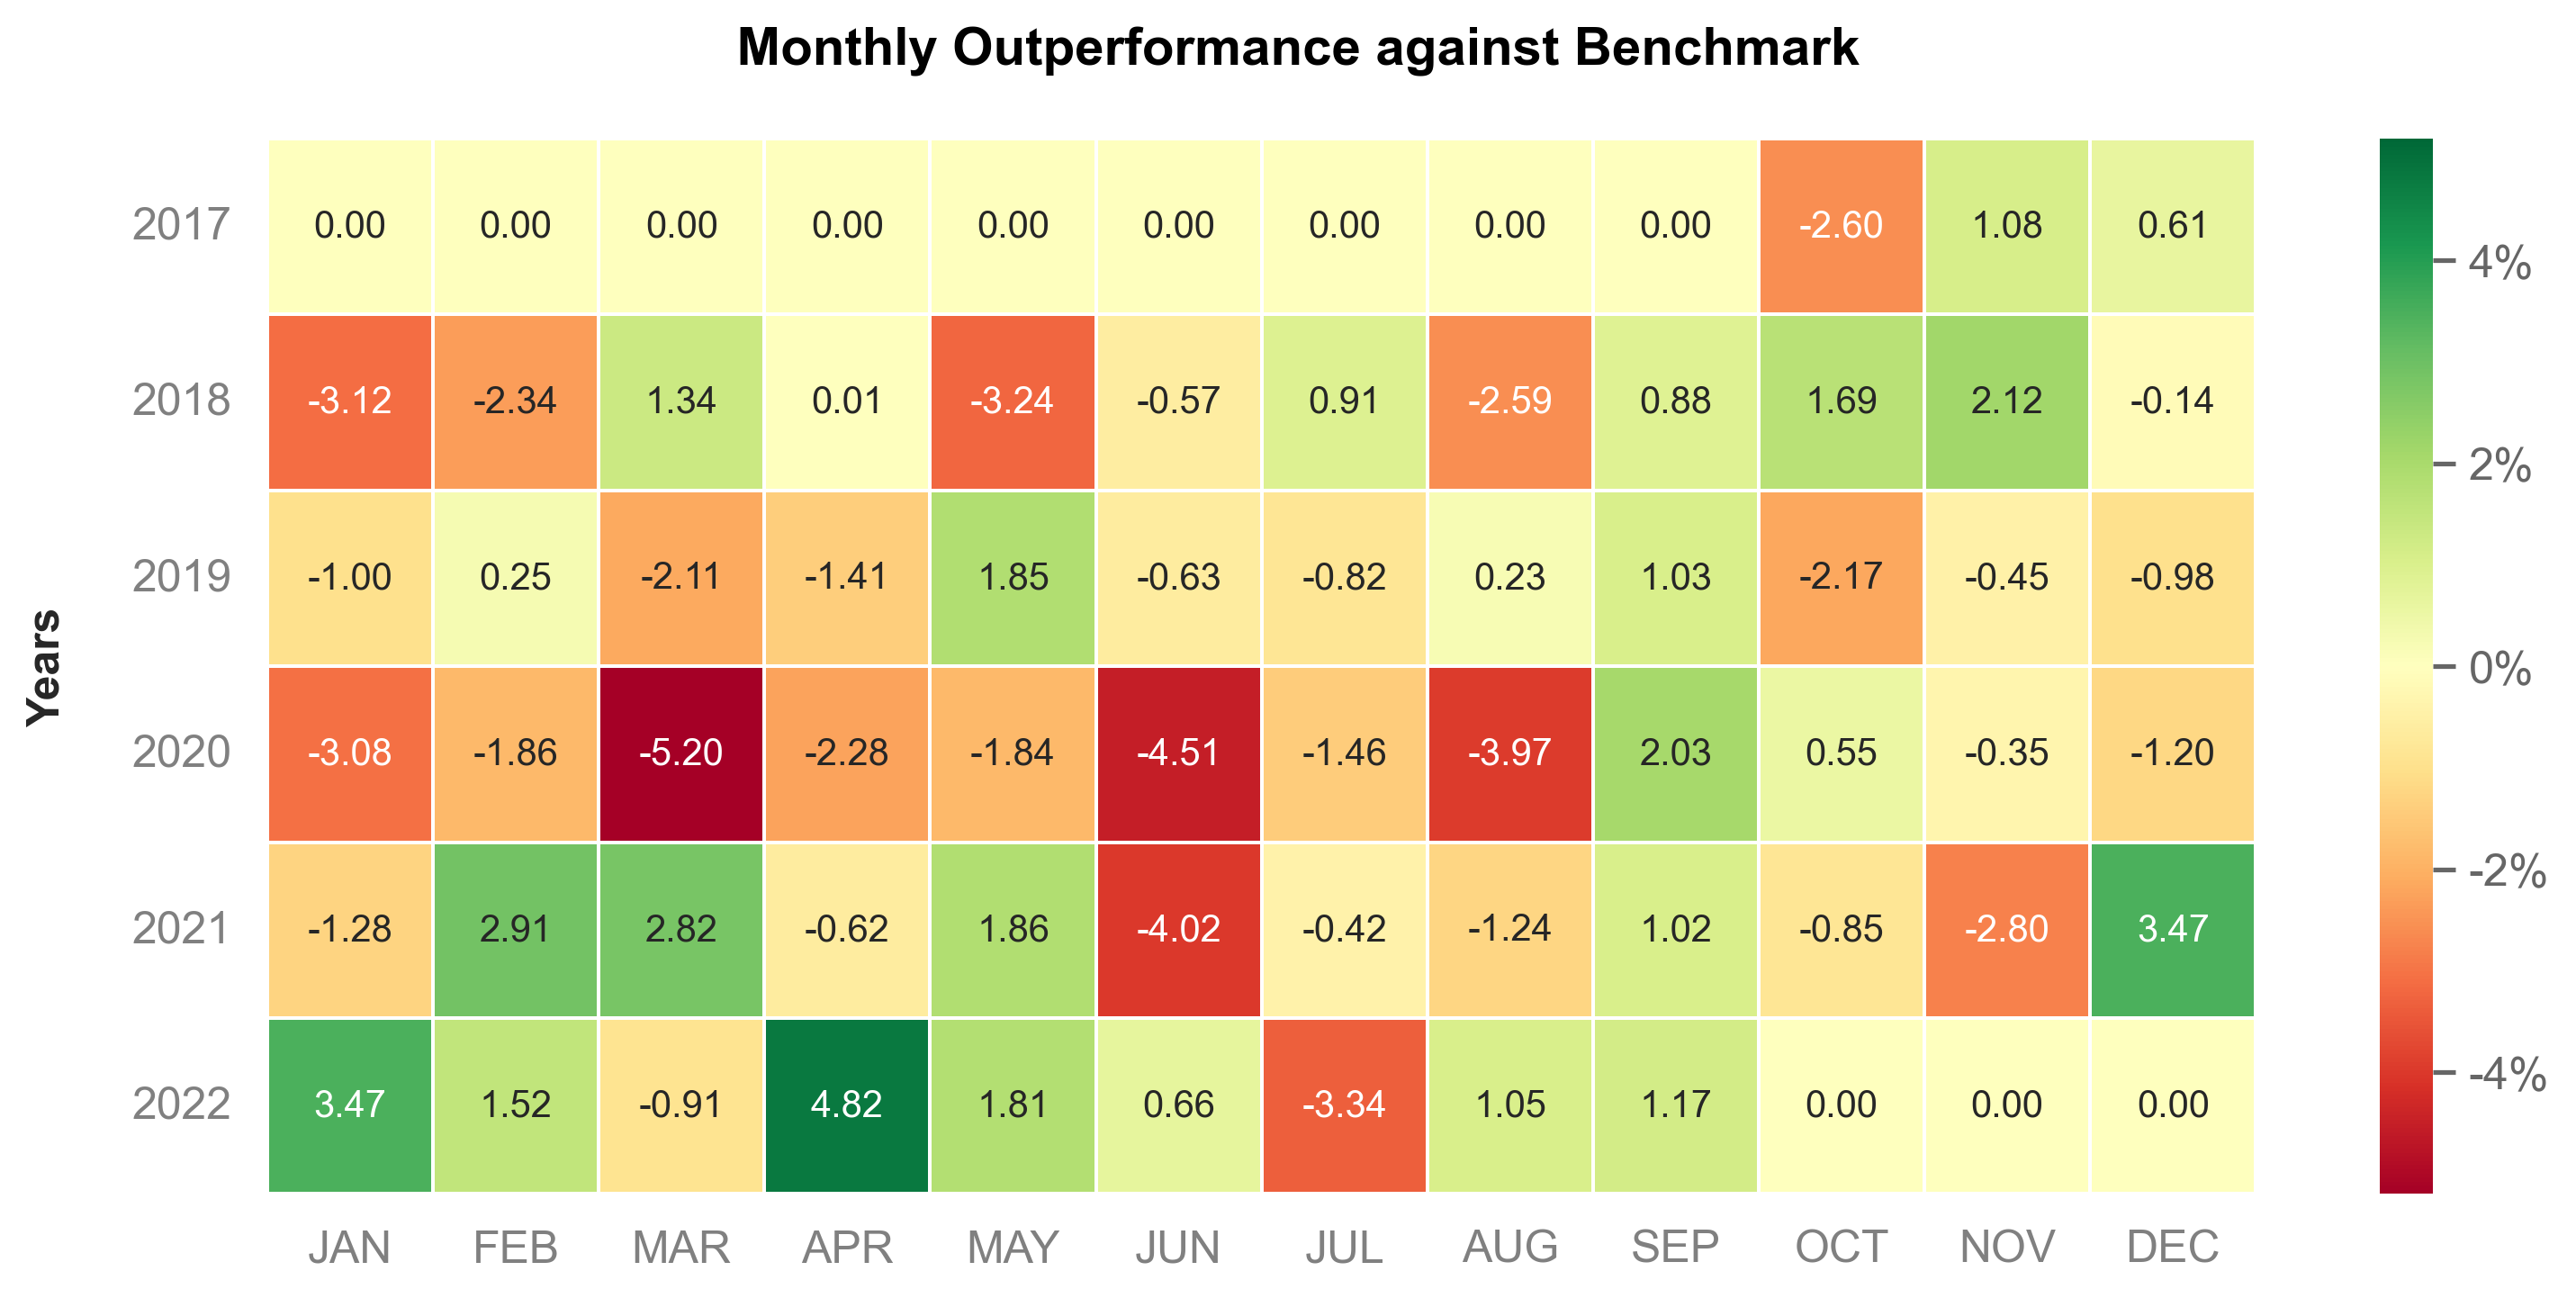

In [ ]:
#| eval: false
values = _utils.download_returns('SPY', '5y')
benchmark = _utils.download_returns('QQQ', '5y')
outperformance_heatmap(values, benchmark)


In [ ]:
#| export

def monthly_returns(returns, annot_size=10, figsize=(10, 5),
                    cbar=True, square=False,
                    compounded=True, eoy=False,
                    grayscale=False, fontname='Arial',
                    ylabel=True, savefig=None, show=True):
    """A wrapper for monthly heatmaps"""
    return monthly_heatmap(returns, annot_size, figsize,
                           cbar, square,
                           compounded, eoy,
                           grayscale, fontname,
                           ylabel, savefig, show)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()